In this test we use the FoF parameters from MAGIC (ie 500km/s & 450kpc). The center is either the barycenter (weighted by Mstar) or the heaviest galaxy when there is one. Mvir and Rvir are computed from **5Rsigma^2/G (as Knoblel+09) but with R as the std** in projected space.

In [1]:
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt
import pandas as pd
from astropy.table import Table
import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy import constants as const
from astropy import units as u
from astropy.coordinates import SkyCoord, Distance
from astropy.cosmology import Planck15
from astropy.cosmology import WMAP9 as cosmo
from scipy.stats import binned_statistic
import matplotlib.backends.backend_pdf

import groups_tools as gid #the important homemade module

%load_ext autoreload
%autoreload 2

# Initial setups

In [34]:
plt.rcParams['text.usetex']=True
plt.rcParams['font.size']=16
plt.rcParams['lines.linewidth']=1.5
plt.rcParams['axes.linewidth']=2.0
plt.rcParams['image.interpolation']='none'
plt.rcParams['xtick.labelsize']='medium'
plt.rcParams['ytick.labelsize']='medium'
plt.rcParams['xtick.minor.visible']=True
plt.rcParams['ytick.minor.visible']=True
plt.rcParams['xtick.minor.size']=4.0
plt.rcParams['xtick.major.size']=8.0
plt.rcParams['ytick.minor.size']=4.0
plt.rcParams['ytick.major.size']=8.0
plt.rcParams['legend.numpoints']=1
plt.rcParams['image.origin']='lower'
plt.rcParams['font.family']='serif'
plt.rcParams['font.serif']='Computer Modern'

In [3]:
# wavelengths:
mgii_a = 2796.352
mgii_b = 2803.530
oii_a = 3727.10
oii_b = 3729.86

muse_min = 4800
muse_max = 9300

uves_min = 3000
uves_max = 11000

In [4]:
z_oii_a_muse_min = muse_min/oii_a -1
z_oii_a_muse_max = muse_max/oii_a -1

z_oii_b_muse_min = muse_min/oii_b -1
z_oii_b_muse_max = muse_max/oii_b -1

z_mgii_a_uves_min = uves_min/mgii_a -1
z_mgii_a_uves_max = uves_max/mgii_a -1

z_mgii_b_uves_min = uves_min/mgii_b -1
z_mgii_b_uves_max = uves_max/mgii_b -1

print("min z for oii in muse = ", z_oii_a_muse_min)
print("max z for oii in muse = ", z_oii_a_muse_max)

print("min z for mgii in uves = ", z_mgii_a_uves_min)
print("max z for mgii in uves = ", z_mgii_a_uves_max)

min z for oii in muse =  0.2878645595771512
max z for oii in muse =  1.4952375841807304
min z for mgii in uves =  0.07282631085070834
max z for mgii in uves =  2.933696473119264


# Data imports

In [5]:
megaflow_data = 'MEGAFLOW_master_dr2.v20220720.fits'
temp = Table.read(megaflow_data, format='fits')
data = temp.to_pandas()
stellar_masses_v01 = pd.read_csv("mass_selectcat_v01b_reconmaster.tb.txt", sep = '|', skipinitialspace=True)
stellar_masses_v02 = pd.read_csv("mass_cat_master_v02psf.tb.txt", sep = "|", skipinitialspace = True)
Abs = pd.read_csv("MgII_all_absorption")
fields_info = pd.read_csv("fields_info_ebv.csv")
cov_table = pd.read_csv("group_abs_coverage_table.csv")

print("N of entries in megaflow: ", len(data))
print("N of entries in stellar_masses v01: ", len(stellar_masses_v01))
print("N of entries in stellar_masses v02: ", len(stellar_masses_v02))
print("N of entries in MgII_all_absorption: ", len(Abs))
print("N of entries in fields_info: ", len(fields_info))
print("N of entries in coverage table: ", len(cov_table))

N of entries in megaflow:  2460
N of entries in stellar_masses v01:  915
N of entries in stellar_masses v02:  21
N of entries in MgII_all_absorption:  126
N of entries in fields_info:  22
N of entries in coverage table:  1216


In [6]:
data = data.astype({'FIELD': 'string'})
data = data.rename(columns={"FIELD": "field_id"})
data = data.rename(columns={"white_ID": "WHITE_ID"})
f1 = data["Z"].isnull() == False
f2 = data["Z"] != 0
f3 = data["ZCONF"] != 0
df = data[f1 & f2 & f3]

In [7]:
fields_list = df["field_id"].unique()
for f in fields_list:
    idx = df.index[df["field_id"] == f].tolist()
    df.loc[idx, "field_id"] = f[2:12]

/home/mcherrey/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


In [8]:
len(df)

2018

In [9]:
df.columns

Index(['ID', 'field_id', 'DATASET', 'FROM', 'Z', 'ZCONF', 'is_QSO', 'RA',
       'DEC', 'B_KPC', 'B_ARCSEC', 'REFSPEC', 'REFCENTER', 'FELINE_ID',
       'fel_ID', 'FEL_score', 'FEL_sigma', 'WHITE_ID', 'SDSS_r', 'SDSS_i',
       'sp_F775W', 'sp_SDSS_r', 'sp_SDSS_i', 'OII3726_FLUX',
       'OII3726_FLUX_ERR', 'OII3726_EQW', 'OII3726_FLUX_EQW', 'OII3729_FLUX',
       'OII3729_FLUX_ERR', 'OII3729_EQW', 'OII3729_EQW_ERR',
       'MGII2796_EMI_FLUX', 'MGII2796_EMI_FLUX_ERR', 'MGII2796_ABS_EQW',
       'MGII2796_ABS_EQW_ERR', 'MGII2803_EMI_FLUX', 'MGII2803_EMI_FLUX_ERR',
       'MGII2803_ABS_EQW', 'MGII2803_ABS_EQW_ERR'],
      dtype='object')

In [10]:
f1 = df["Z"] < z_oii_a_muse_max
f2 = df["Z"] > z_oii_a_muse_min
N_z_oii_muse = len(df[f1 & f2])
N_z_mgii_uves = len(df[df["Z"] < z_mgii_a_uves_max])

print("Number of galaxies located at z compatible with [OII] in Muse: ", N_z_oii_muse)
print("Number of galaxies located at z compatible with MgII in Uves: ", N_z_mgii_uves)

Number of galaxies located at z compatible with [OII] in Muse:  1199
Number of galaxies located at z compatible with MgII in Uves:  1395


# Match the masses

In [11]:
stellar_masses = gid.build_stellar_masses(stellar_masses_v01, stellar_masses_v02)

N of stellar_masses =  936


In [12]:
df = df.merge(stellar_masses, on = "WHITE_ID", how = "left")
len(df[~df["mass"].isna()])

932

For galaxies with no mass, we assign the median mass of the sample in a new column:

In [13]:
df["mass_noNA"] = df["mass"]
idx_nomass = ((df[df["mass"].isna()]).index).tolist()
df.loc[idx_nomass, "mass_noNA"] = df["mass"].median()
len(df[df["mass_noNA"].isna()])

0

In [14]:
f1 = df["mass"].isna()
f2 = df["SDSS_r"].isna()
print("number of galaxies without mass: ", len(df[f1]))
print("number of galaxies without SDSS r: ", len(df[f2]))
print("number of galaxies without nor mass neither SDSS r: ", len(df[f1&f2]))
print("number of galaxies without mass but with SDSS r: ", len(df[f1&~f2]))
print("number of galaxies with mass but without SDSS r: ", len(df[~f1&f2]))

number of galaxies without mass:  1086
number of galaxies without SDSS r:  716
number of galaxies without nor mass neither SDSS r:  716
number of galaxies without mass but with SDSS r:  370
number of galaxies with mass but without SDSS r:  0


**So all the galaxies without mass do not have SDSS r. But some galaxies (370) with SDSS r have no mass.**

In [28]:
QSOs = df[df["is_QSO"] == 1]

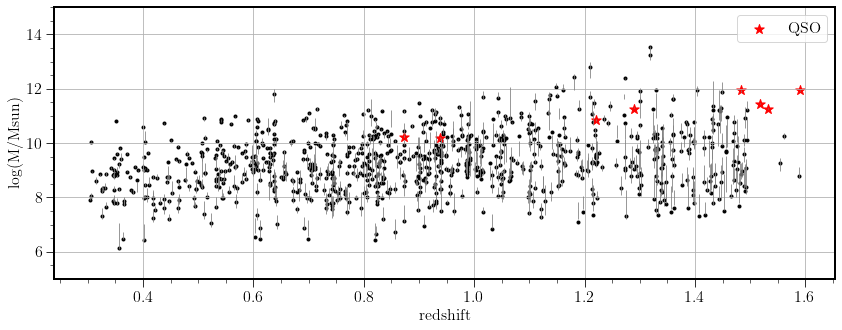

In [35]:
plt.figure(figsize=(14,5))
plt.vlines(df["Z"], df["mass_l68"], df["mass_u68"], color ="gray", linewidth = 0.8)
plt.scatter(df["Z"], df["mass"], marker = ".", c ="black")
plt.scatter(QSOs["Z"], QSOs["mass"], marker = "*", color = "red", s = 100, label = "QSO")
plt.ylim((5, 15))
plt.xlabel("redshift")
plt.ylabel("log(M/Msun)")
plt.grid()
plt.legend()

In [26]:
np.max(df["mass"])

13.52768611907959

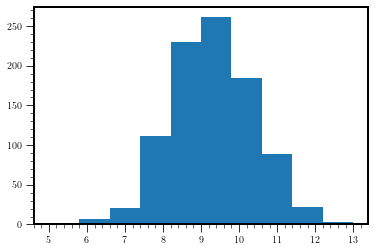

In [24]:
plt.hist(df["mass"], range = (5,13));


In [16]:
df.columns

Index(['ID', 'field_id', 'DATASET', 'FROM', 'Z', 'ZCONF', 'is_QSO', 'RA',
       'DEC', 'B_KPC', 'B_ARCSEC', 'REFSPEC', 'REFCENTER', 'FELINE_ID',
       'fel_ID', 'FEL_score', 'FEL_sigma', 'WHITE_ID', 'SDSS_r', 'SDSS_i',
       'sp_F775W', 'sp_SDSS_r', 'sp_SDSS_i', 'OII3726_FLUX',
       'OII3726_FLUX_ERR', 'OII3726_EQW', 'OII3726_FLUX_EQW', 'OII3729_FLUX',
       'OII3729_FLUX_ERR', 'OII3729_EQW', 'OII3729_EQW_ERR',
       'MGII2796_EMI_FLUX', 'MGII2796_EMI_FLUX_ERR', 'MGII2796_ABS_EQW',
       'MGII2796_ABS_EQW_ERR', 'MGII2803_EMI_FLUX', 'MGII2803_EMI_FLUX_ERR',
       'MGII2803_ABS_EQW', 'MGII2803_ABS_EQW_ERR', 'Unnamed: ', 'ebv',
       'ebv_l68', 'ebv_u68', 'redshift', 'mass', 'mass_l68', 'mass_u68',
       'sfr_100', 'sfr_100_l68', 'sfr_100_u68', 'curr_sfr', 'curr_sfr_l68',
       'curr_sfr_u68', 'age', 'age_l68', 'age_u68', 'q_clump', 'fcov', 'tau',
       'tau_l68', 'tau_u68', 'metallicity', 'imf', 'pw_ratio', 'pw_alpha',
       'sfhtype', 'ebv_steltoneb', 'alpha', 'igm', 'chis

# Adding new fields

### Distances:

In [17]:
df["dist_ang"] = Distance(unit=u.m, z = df["Z"]).value/((1+df["Z"])**2)
df["dist_lum"] = Distance(unit=u.m, z = df["Z"]).value

### Neighbours

In [18]:
df = gid.get_Nxxx_neighb(df, radius = 100)
df = gid.get_Nxxx_neighb(df, radius = 50)

/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  F["dist"] = Distance(unit=u.kpc, z = gal["Z"]).value/((1+gal["Z"])**2)
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:844: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  F["neighb_dist"] = sep.radian*F["dist"]
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  F["dist"] = Distance(unit=u.kpc, z = gal["Z"]).value/((1+gal["Z"])**2)
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:844: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  F["neighb_dist"] = sep.radian*F["dist"]
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  F["dist"] = Distance(unit=u.kpc, z = gal["Z"]).value/((1+gal["Z"])**2)
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:844: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  F["neighb_dist"] = sep.radian*F["dist"]
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  F["dist"] = Distance(unit=u.kpc, z = gal["Z"]).value/((1+gal["Z"])**2)
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:844: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  F["neighb_dist"] = sep.radian*F["dist"]
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  F["dist"] = Distance(unit=u.kpc, z = gal["Z"]).value/((1+gal["Z"])**2)
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:844: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  F["neighb_dist"] = sep.radian*F["dist"]
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  F["dist"] = Distance(unit=u.kpc, z = gal["Z"]).value/((1+gal["Z"])**2)
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:844: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  F["neighb_dist"] = sep.radian*F["dist"]
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  F["dist"] = Distance(unit=u.kpc, z = gal["Z"]).value/((1+gal["Z"])**2)
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:844: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  F["neighb_dist"] = sep.radian*F["dist"]
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  F["dist"] = Distance(unit=u.kpc, z = gal["Z"]).value/((1+gal["Z"])**2)
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:844: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  F["neighb_dist"] = sep.radian*F["dist"]
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  F["dist"] = Distance(unit=u.kpc, z = gal["Z"]).value/((1+gal["Z"])**2)
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:844: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  F["neighb_dist"] = sep.radian*F["dist"]
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  F["dist"] = Distance(unit=u.kpc, z = gal["Z"]).value/((1+gal["Z"])**2)
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:844: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  F["neighb_dist"] = sep.radian*F["dist"]
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  F["dist"] = Distance(unit=u.kpc, z = gal["Z"]).value/((1+gal["Z"])**2)
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:844: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  F["neighb_dist"] = sep.radian*F["dist"]
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:844: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  F["neighb_dist"] = sep.radian*F["dist"]
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  F["dist"] = Distance(unit=u.kpc, z = gal["Z"]).value/((1+gal["Z"])**2)
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:844: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  F["dist"] = Distance(unit=u.kpc, z = gal["Z"]).value/((1+gal["Z"])**2)
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:844: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  F["neighb_dist"] = sep.radian*F["dist"]
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  F["dist"] = Distance(unit=u.kpc, z = gal["Z"]).value/((1+gal["Z"])**2)
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:844: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  F["neighb_dist"] = sep.radian*F["dist"]
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  F["dist"] = Distance(unit=u.kpc, z = gal["Z"]).value/((1+gal["Z"])**2)
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:844: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  F["neighb_dist"] = sep.radian*F["dist"]
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  F["dist"] = Distance(unit=u.kpc, z = gal["Z"]).value/((1+gal["Z"])**2)
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:844: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  F["neighb_dist"] = sep.radian*F["dist"]
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  F["dist"] = Distance(unit=u.kpc, z = gal["Z"]).value/((1+gal["Z"])**2)
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:844: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  F["neighb_dist"] = sep.radian*F["dist"]
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  F["dist"] = Distance(unit=u.kpc, z = gal["Z"]).value/((1+gal["Z"])**2)
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:844: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  F["neighb_dist"] = sep.radian*F["dist"]
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  F["dist"] = Distance(unit=u.kpc, z = gal["Z"]).value/((1+gal["Z"])**2)
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:844: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  F["neighb_dist"] = sep.radian*F["dist"]
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  F["dist"] = Distance(unit=u.kpc, z = gal["Z"]).value/((1+gal["Z"])**2)
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:844: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  F["neighb_dist"] = sep.radian*F["dist"]
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  F["dist"] = Distance(unit=u.kpc, z = gal["Z"]).value/((1+gal["Z"])**2)
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:844: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  F["neighb_dist"] = sep.radian*F["dist"]
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  F["dist"] = Distance(unit=u.kpc, z = gal["Z"]).value/((1+gal["Z"])**2)
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:844: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  F["neighb_dist"] = sep.radian*F["dist"]
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  F["dist"] = Distance(unit=u.kpc, z = gal["Z"]).value/((1+gal["Z"])**2)
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:844: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  F["neighb_dist"] = sep.radian*F["dist"]
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  F["dist"] = Distance(unit=u.kpc, z = gal["Z"]).value/((1+gal["Z"])**2)
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:844: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  F["neighb_dist"] = sep.radian*F["dist"]
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  F["dist"] = Distance(unit=u.kpc, z = gal["Z"]).value/((1+gal["Z"])**2)
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:844: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  F["neighb_dist"] = sep.radian*F["dist"]
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  F["dist"] = Distance(unit=u.kpc, z = gal["Z"]).value/((1+gal["Z"])**2)
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:844: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  F["neighb_dist"] = sep.radian*F["dist"]
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  F["dist"] = Distance(unit=u.kpc, z = gal["Z"]).value/((1+gal["Z"])**2)
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:844: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  F["neighb_dist"] = sep.radian*F["dist"]
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  F["dist"] = Distance(unit=u.kpc, z = gal["Z"]).value/((1+gal["Z"])**2)
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:844: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  F["neighb_dist"] = sep.radian*F["dist"]
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  F["dist"] = Distance(unit=u.kpc, z = gal["Z"]).value/((1+gal["Z"])**2)
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:844: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  F["neighb_dist"] = sep.radian*F["dist"]
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  F["dist"] = Distance(unit=u.kpc, z = gal["Z"]).value/((1+gal["Z"])**2)
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:844: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  F["neighb_dist"] = sep.radian*F["dist"]
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  F["dist"] = Distance(unit=u.kpc, z = gal["Z"]).value/((1+gal["Z"])**2)
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:844: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  F["neighb_dist"] = sep.radian*F["dist"]
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  F["dist"] = Distance(unit=u.kpc, z = gal["Z"]).value/((1+gal["Z"])**2)
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:844: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  F["neighb_dist"] = sep.radian*F["dist"]
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  F["dist"] = Distance(unit=u.kpc, z = gal["Z"]).value/((1+gal["Z"])**2)
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:844: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  F["neighb_dist"] = sep.radian*F["dist"]
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  F["dist"] = Distance(unit=u.kpc, z = gal["Z"]).value/((1+gal["Z"])**2)
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:844: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  F["neighb_dist"] = sep.radian*F["dist"]
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  F["dist"] = Distance(unit=u.kpc, z = gal["Z"]).value/((1+gal["Z"])**2)
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:844: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  F["neighb_dist"] = sep.radian*F["dist"]
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  F["dist"] = Distance(unit=u.kpc, z = gal["Z"]).value/((1+gal["Z"])**2)
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:844: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  F["neighb_dist"] = sep.radian*F["dist"]
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  F["dist"] = Distance(unit=u.kpc, z = gal["Z"]).value/((1+gal["Z"])**2)
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:844: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  F["neighb_dist"] = sep.radian*F["dist"]
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  F["dist"] = Distance(unit=u.kpc, z = gal["Z"]).value/((1+gal["Z"])**2)
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:844: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  F["neighb_dist"] = sep.radian*F["dist"]
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  F["dist"] = Distance(unit=u.kpc, z = gal["Z"]).value/((1+gal["Z"])**2)
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:844: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  F["neighb_dist"] = sep.radian*F["dist"]
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  F["dist"] = Distance(unit=u.kpc, z = gal["Z"]).value/((1+gal["Z"])**2)
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:844: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  F["neighb_dist"] = sep.radian*F["dist"]
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  F["dist"] = Distance(unit=u.kpc, z = gal["Z"]).value/((1+gal["Z"])**2)
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:844: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  F["neighb_dist"] = sep.radian*F["dist"]
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  F["dist"] = Distance(unit=u.kpc, z = gal["Z"]).value/((1+gal["Z"])**2)
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:844: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  F["neighb_dist"] = sep.radian*F["dist"]
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  F["dist"] = Distance(unit=u.kpc, z = gal["Z"]).value/((1+gal["Z"])**2)
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:844: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  F["neighb_dist"] = sep.radian*F["dist"]
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  F["dist"] = Distance(unit=u.kpc, z = gal["Z"]).value/((1+gal["Z"])**2)
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:844: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  F["neighb_dist"] = sep.radian*F["dist"]
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  F["dist"] = Distance(unit=u.kpc, z = gal["Z"]).value/((1+gal["Z"])**2)
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:844: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  F["neighb_dist"] = sep.radian*F["dist"]
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  F["dist"] = Distance(unit=u.kpc, z = gal["Z"]).value/((1+gal["Z"])**2)
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:844: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  F["neighb_dist"] = sep.radian*F["dist"]
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  F["dist"] = Distance(unit=u.kpc, z = gal["Z"]).value/((1+gal["Z"])**2)
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:844: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  F["neighb_dist"] = sep.radian*F["dist"]
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  F["dist"] = Distance(unit=u.kpc, z = gal["Z"]).value/((1+gal["Z"])**2)
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:844: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  F["neighb_dist"] = sep.radian*F["dist"]
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  F["dist"] = Distance(unit=u.kpc, z = gal["Z"]).value/((1+gal["Z"])**2)
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:844: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  F["neighb_dist"] = sep.radian*F["dist"]
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:844: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  F["neighb_dist"] = sep.radian*F["dist"]
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  F["dist"] = Distance(unit=u.kpc, z = gal["Z"]).value/((1+gal["Z"])**2)
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:844: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  F["dist"] = Distance(unit=u.kpc, z = gal["Z"]).value/((1+gal["Z"])**2)
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:844: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  F["neighb_dist"] = sep.radian*F["dist"]
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  F["dist"] = Distance(unit=u.kpc, z = gal["Z"]).value/((1+gal["Z"])**2)
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:844: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  F["neighb_dist"] = sep.radian*F["dist"]
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  F["dist"] = Distance(unit=u.kpc, z = gal["Z"]).value/((1+gal["Z"])**2)
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:844: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  F["neighb_dist"] = sep.radian*F["dist"]
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  F["dist"] = Distance(unit=u.kpc, z = gal["Z"]).value/((1+gal["Z"])**2)
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:844: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  F["neighb_dist"] = sep.radian*F["dist"]
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  F["dist"] = Distance(unit=u.kpc, z = gal["Z"]).value/((1+gal["Z"])**2)
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:844: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  F["neighb_dist"] = sep.radian*F["dist"]
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  F["dist"] = Distance(unit=u.kpc, z = gal["Z"]).value/((1+gal["Z"])**2)
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:844: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  F["neighb_dist"] = sep.radian*F["dist"]
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  F["dist"] = Distance(unit=u.kpc, z = gal["Z"]).value/((1+gal["Z"])**2)
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:844: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  F["neighb_dist"] = sep.radian*F["dist"]
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  F["dist"] = Distance(unit=u.kpc, z = gal["Z"]).value/((1+gal["Z"])**2)
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:844: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  F["neighb_dist"] = sep.radian*F["dist"]
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  F["dist"] = Distance(unit=u.kpc, z = gal["Z"]).value/((1+gal["Z"])**2)
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:844: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  F["neighb_dist"] = sep.radian*F["dist"]
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  F["dist"] = Distance(unit=u.kpc, z = gal["Z"]).value/((1+gal["Z"])**2)
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:844: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  F["neighb_dist"] = sep.radian*F["dist"]
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  F["dist"] = Distance(unit=u.kpc, z = gal["Z"]).value/((1+gal["Z"])**2)
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:844: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  F["neighb_dist"] = sep.radian*F["dist"]
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  F["dist"] = Distance(unit=u.kpc, z = gal["Z"]).value/((1+gal["Z"])**2)
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:844: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  F["neighb_dist"] = sep.radian*F["dist"]
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  F["dist"] = Distance(unit=u.kpc, z = gal["Z"]).value/((1+gal["Z"])**2)
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:844: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  F["neighb_dist"] = sep.radian*F["dist"]
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  F["dist"] = Distance(unit=u.kpc, z = gal["Z"]).value/((1+gal["Z"])**2)
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:844: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  F["neighb_dist"] = sep.radian*F["dist"]
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  F["dist"] = Distance(unit=u.kpc, z = gal["Z"]).value/((1+gal["Z"])**2)
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:844: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  F["neighb_dist"] = sep.radian*F["dist"]
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  F["dist"] = Distance(unit=u.kpc, z = gal["Z"]).value/((1+gal["Z"])**2)
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:844: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  F["neighb_dist"] = sep.radian*F["dist"]
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:844: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  F["neighb_dist"] = sep.radian*F["dist"]
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  F["dist"] = Distance(unit=u.kpc, z = gal["Z"]).value/((1+gal["Z"])**2)
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:844: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  F["dist"] = Distance(unit=u.kpc, z = gal["Z"]).value/((1+gal["Z"])**2)
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:844: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  F["neighb_dist"] = sep.radian*F["dist"]
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  F["dist"] = Distance(unit=u.kpc, z = gal["Z"]).value/((1+gal["Z"])**2)
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:844: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  F["neighb_dist"] = sep.radian*F["dist"]
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  F["dist"] = Distance(unit=u.kpc, z = gal["Z"]).value/((1+gal["Z"])**2)
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:844: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  F["neighb_dist"] = sep.radian*F["dist"]
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  F["dist"] = Distance(unit=u.kpc, z = gal["Z"]).value/((1+gal["Z"])**2)
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:844: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  F["neighb_dist"] = sep.radian*F["dist"]
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  F["dist"] = Distance(unit=u.kpc, z = gal["Z"]).value/((1+gal["Z"])**2)
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:844: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  F["neighb_dist"] = sep.radian*F["dist"]
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  F["dist"] = Distance(unit=u.kpc, z = gal["Z"]).value/((1+gal["Z"])**2)
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:844: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  F["neighb_dist"] = sep.radian*F["dist"]
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  F["dist"] = Distance(unit=u.kpc, z = gal["Z"]).value/((1+gal["Z"])**2)
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:844: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  F["neighb_dist"] = sep.radian*F["dist"]
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  F["dist"] = Distance(unit=u.kpc, z = gal["Z"]).value/((1+gal["Z"])**2)
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:844: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  F["neighb_dist"] = sep.radian*F["dist"]
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  F["dist"] = Distance(unit=u.kpc, z = gal["Z"]).value/((1+gal["Z"])**2)
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:844: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  F["neighb_dist"] = sep.radian*F["dist"]
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  F["dist"] = Distance(unit=u.kpc, z = gal["Z"]).value/((1+gal["Z"])**2)
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:844: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  F["neighb_dist"] = sep.radian*F["dist"]
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  F["dist"] = Distance(unit=u.kpc, z = gal["Z"]).value/((1+gal["Z"])**2)
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:844: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  F["neighb_dist"] = sep.radian*F["dist"]
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  F["dist"] = Distance(unit=u.kpc, z = gal["Z"]).value/((1+gal["Z"])**2)
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:844: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  F["neighb_dist"] = sep.radian*F["dist"]
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  F["dist"] = Distance(unit=u.kpc, z = gal["Z"]).value/((1+gal["Z"])**2)
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:844: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  F["neighb_dist"] = sep.radian*F["dist"]
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  F["dist"] = Distance(unit=u.kpc, z = gal["Z"]).value/((1+gal["Z"])**2)
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:844: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  F["neighb_dist"] = sep.radian*F["dist"]
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  F["dist"] = Distance(unit=u.kpc, z = gal["Z"]).value/((1+gal["Z"])**2)
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:844: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  F["neighb_dist"] = sep.radian*F["dist"]
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  F["dist"] = Distance(unit=u.kpc, z = gal["Z"]).value/((1+gal["Z"])**2)
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:844: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  F["neighb_dist"] = sep.radian*F["dist"]
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  F["dist"] = Distance(unit=u.kpc, z = gal["Z"]).value/((1+gal["Z"])**2)
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:844: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  F["neighb_dist"] = sep.radian*F["dist"]
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  F["dist"] = Distance(unit=u.kpc, z = gal["Z"]).value/((1+gal["Z"])**2)
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:844: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  F["neighb_dist"] = sep.radian*F["dist"]
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  F["dist"] = Distance(unit=u.kpc, z = gal["Z"]).value/((1+gal["Z"])**2)
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:844: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  F["neighb_dist"] = sep.radian*F["dist"]
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  F["dist"] = Distance(unit=u.kpc, z = gal["Z"]).value/((1+gal["Z"])**2)
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:844: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  F["neighb_dist"] = sep.radian*F["dist"]
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:844: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  F["neighb_dist"] = sep.radian*F["dist"]
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  F["dist"] = Distance(unit=u.kpc, z = gal["Z"]).value/((1+gal["Z"])**2)
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:844: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:844: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  F["neighb_dist"] = sep.radian*F["dist"]
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  F["dist"] = Distance(unit=u.kpc, z = gal["Z"]).value/((1+gal["Z"])**2)
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:844: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  F["dist"] = Distance(unit=u.kpc, z = gal["Z"]).value/((1+gal["Z"])**2)
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:844: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  F["neighb_dist"] = sep.radian*F["dist"]
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  F["dist"] = Distance(unit=u.kpc, z = gal["Z"]).value/((1+gal["Z"])**2)
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:844: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  F["neighb_dist"] = sep.radian*F["dist"]
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  F["dist"] = Distance(unit=u.kpc, z = gal["Z"]).value/((1+gal["Z"])**2)
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:844: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  F["neighb_dist"] = sep.radian*F["dist"]
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  F["dist"] = Distance(unit=u.kpc, z = gal["Z"]).value/((1+gal["Z"])**2)
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:844: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  F["neighb_dist"] = sep.radian*F["dist"]
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  F["dist"] = Distance(unit=u.kpc, z = gal["Z"]).value/((1+gal["Z"])**2)
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:844: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  F["neighb_dist"] = sep.radian*F["dist"]
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  F["dist"] = Distance(unit=u.kpc, z = gal["Z"]).value/((1+gal["Z"])**2)
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:844: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  F["neighb_dist"] = sep.radian*F["dist"]
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  F["dist"] = Distance(unit=u.kpc, z = gal["Z"]).value/((1+gal["Z"])**2)
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:844: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  F["neighb_dist"] = sep.radian*F["dist"]
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  F["dist"] = Distance(unit=u.kpc, z = gal["Z"]).value/((1+gal["Z"])**2)
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:844: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  F["neighb_dist"] = sep.radian*F["dist"]
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  F["dist"] = Distance(unit=u.kpc, z = gal["Z"]).value/((1+gal["Z"])**2)
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:844: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  F["neighb_dist"] = sep.radian*F["dist"]
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  F["dist"] = Distance(unit=u.kpc, z = gal["Z"]).value/((1+gal["Z"])**2)
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:844: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  F["neighb_dist"] = sep.radian*F["dist"]
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  F["dist"] = Distance(unit=u.kpc, z = gal["Z"]).value/((1+gal["Z"])**2)
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:844: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  F["neighb_dist"] = sep.radian*F["dist"]
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  F["dist"] = Distance(unit=u.kpc, z = gal["Z"]).value/((1+gal["Z"])**2)
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:844: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  F["neighb_dist"] = sep.radian*F["dist"]
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  F["dist"] = Distance(unit=u.kpc, z = gal["Z"]).value/((1+gal["Z"])**2)
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:844: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  F["neighb_dist"] = sep.radian*F["dist"]
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  F["dist"] = Distance(unit=u.kpc, z = gal["Z"]).value/((1+gal["Z"])**2)
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:844: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  F["neighb_dist"] = sep.radian*F["dist"]
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  F["dist"] = Distance(unit=u.kpc, z = gal["Z"]).value/((1+gal["Z"])**2)
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:844: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  F["neighb_dist"] = sep.radian*F["dist"]
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  F["dist"] = Distance(unit=u.kpc, z = gal["Z"]).value/((1+gal["Z"])**2)
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:844: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  F["neighb_dist"] = sep.radian*F["dist"]
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  F["dist"] = Distance(unit=u.kpc, z = gal["Z"]).value/((1+gal["Z"])**2)
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:844: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  F["neighb_dist"] = sep.radian*F["dist"]
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  F["dist"] = Distance(unit=u.kpc, z = gal["Z"]).value/((1+gal["Z"])**2)
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:844: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  F["neighb_dist"] = sep.radian*F["dist"]
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  F["dist"] = Distance(unit=u.kpc, z = gal["Z"]).value/((1+gal["Z"])**2)
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:844: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  F["neighb_dist"] = sep.radian*F["dist"]
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  F["dist"] = Distance(unit=u.kpc, z = gal["Z"]).value/((1+gal["Z"])**2)
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:844: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  F["neighb_dist"] = sep.radian*F["dist"]
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  F["dist"] = Distance(unit=u.kpc, z = gal["Z"]).value/((1+gal["Z"])**2)
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:844: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  F["neighb_dist"] = sep.radian*F["dist"]
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  F["dist"] = Distance(unit=u.kpc, z = gal["Z"]).value/((1+gal["Z"])**2)
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:844: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  F["neighb_dist"] = sep.radian*F["dist"]
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  F["dist"] = Distance(unit=u.kpc, z = gal["Z"]).value/((1+gal["Z"])**2)
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:844: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  F["neighb_dist"] = sep.radian*F["dist"]
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  F["dist"] = Distance(unit=u.kpc, z = gal["Z"]).value/((1+gal["Z"])**2)
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:844: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  F["neighb_dist"] = sep.radian*F["dist"]
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  F["dist"] = Distance(unit=u.kpc, z = gal["Z"]).value/((1+gal["Z"])**2)
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:844: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  F["neighb_dist"] = sep.radian*F["dist"]
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  F["dist"] = Distance(unit=u.kpc, z = gal["Z"]).value/((1+gal["Z"])**2)
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:844: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  F["neighb_dist"] = sep.radian*F["dist"]
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  F["dist"] = Distance(unit=u.kpc, z = gal["Z"]).value/((1+gal["Z"])**2)
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:844: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  F["neighb_dist"] = sep.radian*F["dist"]
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  F["dist"] = Distance(unit=u.kpc, z = gal["Z"]).value/((1+gal["Z"])**2)
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:844: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  F["neighb_dist"] = sep.radian*F["dist"]
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  F["dist"] = Distance(unit=u.kpc, z = gal["Z"]).value/((1+gal["Z"])**2)
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:844: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  F["neighb_dist"] = sep.radian*F["dist"]
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  F["dist"] = Distance(unit=u.kpc, z = gal["Z"]).value/((1+gal["Z"])**2)
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:844: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  F["neighb_dist"] = sep.radian*F["dist"]
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  F["dist"] = Distance(unit=u.kpc, z = gal["Z"]).value/((1+gal["Z"])**2)
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:844: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  F["neighb_dist"] = sep.radian*F["dist"]
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  F["dist"] = Distance(unit=u.kpc, z = gal["Z"]).value/((1+gal["Z"])**2)
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:844: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  F["neighb_dist"] = sep.radian*F["dist"]
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  F["dist"] = Distance(unit=u.kpc, z = gal["Z"]).value/((1+gal["Z"])**2)
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:844: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  F["neighb_dist"] = sep.radian*F["dist"]
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  F["dist"] = Distance(unit=u.kpc, z = gal["Z"]).value/((1+gal["Z"])**2)
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:844: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  F["neighb_dist"] = sep.radian*F["dist"]
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  F["dist"] = Distance(unit=u.kpc, z = gal["Z"]).value/((1+gal["Z"])**2)
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:844: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  F["neighb_dist"] = sep.radian*F["dist"]
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  F["dist"] = Distance(unit=u.kpc, z = gal["Z"]).value/((1+gal["Z"])**2)
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:844: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  F["neighb_dist"] = sep.radian*F["dist"]
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  F["dist"] = Distance(unit=u.kpc, z = gal["Z"]).value/((1+gal["Z"])**2)
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:844: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  F["neighb_dist"] = sep.radian*F["dist"]
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  F["dist"] = Distance(unit=u.kpc, z = gal["Z"]).value/((1+gal["Z"])**2)
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:844: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  F["neighb_dist"] = sep.radian*F["dist"]
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  F["dist"] = Distance(unit=u.kpc, z = gal["Z"]).value/((1+gal["Z"])**2)
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:844: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  F["neighb_dist"] = sep.radian*F["dist"]
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  F["dist"] = Distance(unit=u.kpc, z = gal["Z"]).value/((1+gal["Z"])**2)
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:844: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  F["neighb_dist"] = sep.radian*F["dist"]
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  F["dist"] = Distance(unit=u.kpc, z = gal["Z"]).value/((1+gal["Z"])**2)
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:844: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  F["neighb_dist"] = sep.radian*F["dist"]
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  F["dist"] = Distance(unit=u.kpc, z = gal["Z"]).value/((1+gal["Z"])**2)
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:844: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  F["neighb_dist"] = sep.radian*F["dist"]
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  F["dist"] = Distance(unit=u.kpc, z = gal["Z"]).value/((1+gal["Z"])**2)
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:844: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  F["neighb_dist"] = sep.radian*F["dist"]
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  F["dist"] = Distance(unit=u.kpc, z = gal["Z"]).value/((1+gal["Z"])**2)
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:844: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  F["neighb_dist"] = sep.radian*F["dist"]
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  F["dist"] = Distance(unit=u.kpc, z = gal["Z"]).value/((1+gal["Z"])**2)
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:844: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  F["neighb_dist"] = sep.radian*F["dist"]
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  F["dist"] = Distance(unit=u.kpc, z = gal["Z"]).value/((1+gal["Z"])**2)
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:844: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  F["neighb_dist"] = sep.radian*F["dist"]
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  F["dist"] = Distance(unit=u.kpc, z = gal["Z"]).value/((1+gal["Z"])**2)
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:844: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  F["neighb_dist"] = sep.radian*F["dist"]
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  F["dist"] = Distance(unit=u.kpc, z = gal["Z"]).value/((1+gal["Z"])**2)
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:844: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  F["neighb_dist"] = sep.radian*F["dist"]
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  F["dist"] = Distance(unit=u.kpc, z = gal["Z"]).value/((1+gal["Z"])**2)
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:844: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  F["neighb_dist"] = sep.radian*F["dist"]
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:844: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  F["neighb_dist"] = sep.radian*F["dist"]
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  F["dist"] = Distance(unit=u.kpc, z = gal["Z"]).value/((1+gal["Z"])**2)
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:844: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  F["dist"] = Distance(unit=u.kpc, z = gal["Z"]).value/((1+gal["Z"])**2)
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:844: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  F["neighb_dist"] = sep.radian*F["dist"]
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  F["dist"] = Distance(unit=u.kpc, z = gal["Z"]).value/((1+gal["Z"])**2)
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:844: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  F["neighb_dist"] = sep.radian*F["dist"]
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  F["dist"] = Distance(unit=u.kpc, z = gal["Z"]).value/((1+gal["Z"])**2)
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:844: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  F["neighb_dist"] = sep.radian*F["dist"]
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  F["dist"] = Distance(unit=u.kpc, z = gal["Z"]).value/((1+gal["Z"])**2)
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:844: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  F["neighb_dist"] = sep.radian*F["dist"]
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  F["dist"] = Distance(unit=u.kpc, z = gal["Z"]).value/((1+gal["Z"])**2)
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:844: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  F["neighb_dist"] = sep.radian*F["dist"]
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  F["dist"] = Distance(unit=u.kpc, z = gal["Z"]).value/((1+gal["Z"])**2)
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:844: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  F["neighb_dist"] = sep.radian*F["dist"]
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  F["dist"] = Distance(unit=u.kpc, z = gal["Z"]).value/((1+gal["Z"])**2)
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:844: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  F["neighb_dist"] = sep.radian*F["dist"]
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  F["dist"] = Distance(unit=u.kpc, z = gal["Z"]).value/((1+gal["Z"])**2)
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:844: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  F["neighb_dist"] = sep.radian*F["dist"]
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  F["dist"] = Distance(unit=u.kpc, z = gal["Z"]).value/((1+gal["Z"])**2)
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:844: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  F["neighb_dist"] = sep.radian*F["dist"]
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  F["dist"] = Distance(unit=u.kpc, z = gal["Z"]).value/((1+gal["Z"])**2)
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:844: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  F["neighb_dist"] = sep.radian*F["dist"]
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  F["dist"] = Distance(unit=u.kpc, z = gal["Z"]).value/((1+gal["Z"])**2)
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:844: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  F["neighb_dist"] = sep.radian*F["dist"]
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  F["dist"] = Distance(unit=u.kpc, z = gal["Z"]).value/((1+gal["Z"])**2)
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:844: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  F["neighb_dist"] = sep.radian*F["dist"]
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  F["dist"] = Distance(unit=u.kpc, z = gal["Z"]).value/((1+gal["Z"])**2)
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:844: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  F["neighb_dist"] = sep.radian*F["dist"]
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  F["dist"] = Distance(unit=u.kpc, z = gal["Z"]).value/((1+gal["Z"])**2)
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:844: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  F["neighb_dist"] = sep.radian*F["dist"]
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  F["dist"] = Distance(unit=u.kpc, z = gal["Z"]).value/((1+gal["Z"])**2)
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:844: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  F["neighb_dist"] = sep.radian*F["dist"]
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  F["dist"] = Distance(unit=u.kpc, z = gal["Z"]).value/((1+gal["Z"])**2)
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:844: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  F["neighb_dist"] = sep.radian*F["dist"]
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  F["dist"] = Distance(unit=u.kpc, z = gal["Z"]).value/((1+gal["Z"])**2)
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:844: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  F["neighb_dist"] = sep.radian*F["dist"]
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  F["dist"] = Distance(unit=u.kpc, z = gal["Z"]).value/((1+gal["Z"])**2)
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:844: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  F["neighb_dist"] = sep.radian*F["dist"]
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  F["dist"] = Distance(unit=u.kpc, z = gal["Z"]).value/((1+gal["Z"])**2)
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:844: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  F["neighb_dist"] = sep.radian*F["dist"]
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  F["dist"] = Distance(unit=u.kpc, z = gal["Z"]).value/((1+gal["Z"])**2)
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:844: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  F["neighb_dist"] = sep.radian*F["dist"]
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  F["dist"] = Distance(unit=u.kpc, z = gal["Z"]).value/((1+gal["Z"])**2)
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:844: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  F["neighb_dist"] = sep.radian*F["dist"]
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  F["dist"] = Distance(unit=u.kpc, z = gal["Z"]).value/((1+gal["Z"])**2)
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:844: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  F["neighb_dist"] = sep.radian*F["dist"]
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  F["dist"] = Distance(unit=u.kpc, z = gal["Z"]).value/((1+gal["Z"])**2)
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:844: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  F["neighb_dist"] = sep.radian*F["dist"]
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  F["dist"] = Distance(unit=u.kpc, z = gal["Z"]).value/((1+gal["Z"])**2)
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:844: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  F["neighb_dist"] = sep.radian*F["dist"]
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  F["dist"] = Distance(unit=u.kpc, z = gal["Z"]).value/((1+gal["Z"])**2)
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:844: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  F["neighb_dist"] = sep.radian*F["dist"]
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  F["dist"] = Distance(unit=u.kpc, z = gal["Z"]).value/((1+gal["Z"])**2)
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:844: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  F["neighb_dist"] = sep.radian*F["dist"]
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  F["dist"] = Distance(unit=u.kpc, z = gal["Z"]).value/((1+gal["Z"])**2)
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:844: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  F["neighb_dist"] = sep.radian*F["dist"]
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  F["dist"] = Distance(unit=u.kpc, z = gal["Z"]).value/((1+gal["Z"])**2)
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:844: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  F["neighb_dist"] = sep.radian*F["dist"]
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  F["dist"] = Distance(unit=u.kpc, z = gal["Z"]).value/((1+gal["Z"])**2)
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:844: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  F["neighb_dist"] = sep.radian*F["dist"]
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  F["dist"] = Distance(unit=u.kpc, z = gal["Z"]).value/((1+gal["Z"])**2)
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:844: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  F["neighb_dist"] = sep.radian*F["dist"]
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  F["dist"] = Distance(unit=u.kpc, z = gal["Z"]).value/((1+gal["Z"])**2)
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:844: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  F["neighb_dist"] = sep.radian*F["dist"]
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  F["dist"] = Distance(unit=u.kpc, z = gal["Z"]).value/((1+gal["Z"])**2)
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:844: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  F["neighb_dist"] = sep.radian*F["dist"]
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  F["dist"] = Distance(unit=u.kpc, z = gal["Z"]).value/((1+gal["Z"])**2)
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:844: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  F["neighb_dist"] = sep.radian*F["dist"]
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:844: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  F["neighb_dist"] = sep.radian*F["dist"]
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:843: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  F["dist"] = Distance(unit=u.kpc, z = gal["Z"]).value/((1+gal["Z"])**2)
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:844: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

# Some theoretical calculations:

### Overdensities caracterisation

The number of galaxies that we expect to find in a cylinder of 100 kpc radius and +- 1000 km/s depth chosen at a 'random' place in the universe at redshift 1 is: 

In [19]:
z = [1]
M = [0]
d = np.array([z,M])
ref_sample = pd.DataFrame(d.T, columns = ["mean_z", "M_vel_disp"])
ref_sample = gid.get_all_expected_group_density(ref_sample, Radius = 100);
print("Nb of galaxies expected at a random place: ", round(float(ref_sample["N100_exp"].values),2), "+-", round(float(ref_sample["N100_exp_sigma"].values), 2))

R0 =  0
Z =  1       rz =  8319.340288578165
0.05227195666662151 0.05227195666662151 0.0 8319.340288578165
Nb of galaxies expected at a random place:  0.05 +- 0.23


/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:1008: RuntimeWarning: divide by zero encountered in log10
  logM = np.log10(M)


In [20]:
N_exp = float(ref_sample["N100_exp"].values)
N_exp_sigma = float(ref_sample["N100_exp_sigma"].values)
print("with 68% CL, we expect not more than: ", round(N_exp + N_exp_sigma, 2), "galaxies")
print("with 95% CL, we expect not more than: ", round(N_exp + 2*N_exp_sigma, 2), "galaxies")
print("with 99.7% CL, we expect not more than: ", round(N_exp + 3*N_exp_sigma, 2), "galaxies")

with 68% CL, we expect not more than:  0.28 galaxies
with 95% CL, we expect not more than:  0.51 galaxies
with 99.7% CL, we expect not more than:  0.74 galaxies


Now, if we pick a galaxy (let say of mass $1e11 M_{\odot}$), the probability to find another one in a 100 kpc radius is: 

In [21]:
z = [1]
M = [1e11]
d = np.array([z,M])
ref_sample2 = pd.DataFrame(d.T, columns = ["mean_z", "M_vel_disp"])
ref_sample2 = gid.get_all_expected_group_density(ref_sample2, Radius = 100, dv = 0.5e6);
print("Nb of galaxies expected at a random place: ", round(float(ref_sample2["N100_exp"].values),2), "+-", round(float(ref_sample2["N100_exp_sigma"].values), 2))


R0 =  2079.6
Z =  1.0       rz =  4159.670144289083
0.4319789415302203 0.026135978333310755 0.26746123561661245 4159.670144289083
Nb of galaxies expected at a random place:  0.43 +- 0.84


And for the whole Muse field, we can take a cylinder with the same area as the MUSE FOV:

In [22]:
angr = np.sqrt(3600/np.pi)*u.arcsec
#sep = 0.5*u.arcmin
#sep = 30*u.arcsec
sep = angr.to(u.radian)
rr = sep.value*Distance(unit=u.kpc, z = 1).value/((1+1)**2)
rr = int(np.round(rr))
print("radius: ", rr)

z = [1]
M = [1e11]
d = np.array([z,M])
ref_sample2 = pd.DataFrame(d.T, columns = ["mean_z", "M_vel_disp"])
ref_sample2 = gid.get_all_expected_group_density(ref_sample2, Radius = rr, dv = 0.5e6);
print("Nb of galaxies expected at a random place: ", round(float(ref_sample2["N279_exp"].values),2), "+-", round(float(ref_sample2["N279_exp_sigma"].values), 2))

radius:  279
R0 =  2079.6
Z =  1.0       rz =  4159.670144289083
1.5948579509629193 0.20344506894432426 2.6360777772187007 4159.670144289083
Nb of galaxies expected at a random place:  1.59 +- 2.06


### Nb of groups expected

According to Girelli 2020 Girelli 2020 (or  Hernandez-Aguayo 2018, or https://doi.org/10.1093/mnras/sty2270), we expect around 3e-4 halos of more than 1e13 Msun per Mpc3.h-3  
and approx 1e-3 halos ofr more than 1e12 Msun
![image.png](attachment:image.png)

In [23]:
Vmegaflow = gid.Vmegaflow(z_oii_a_muse_min, z_oii_b_muse_max) # in comoving Mpc3
Vmegaflow

<Quantity 1887.89461126 Mpc3>

In [24]:
z_oii_b_muse_min

0.2869115730885341

So we expect:

In [25]:
print("We expect ~", np.round(Vmegaflow.value*10**(-3.7), 2), "groups with halo mass above 1e13 Msun per field")
print("We expect ~", np.round(Vmegaflow.value*10**(-3), 2), "groups with halo mass above 1e12 Msun per field")
print("We expect ~", np.round(22*Vmegaflow.value*10**(-3.7), 1), "groups with halo mass above 1e13 Msun")
print("We expect ~", np.round(22*Vmegaflow.value*10**(-3), 1), "groups with halo mass above 1e12 Msun")

We expect ~ 0.38 groups with halo mass above 1e13 Msun per field
We expect ~ 1.89 groups with halo mass above 1e12 Msun per field
We expect ~ 8.3 groups with halo mass above 1e13 Msun
We expect ~ 41.5 groups with halo mass above 1e12 Msun


# I. FoF algorithm

In [26]:
#R_fof = gid.FoF(df, D0 = 500, V0 = 400) #Using the parameters of Huchra & Geller, tested on TNG100 at z = 1

In [27]:
#R_fof.to_csv("R_real_fof_500_400_raw.csv", index = False)
#R_fof.to_csv("R_real_fof_630_400_raw.csv", index = False)
R_fof = pd.read_csv("R_real_fof_450_500_raw.csv", index_col = False)

In [28]:
G_fof = gid.get_groups(R_fof, N_min = 1)
G3_fof = gid.get_groups(R_fof, N_min = 3)
G5_fof = gid.get_groups(R_fof, N_min = 5)

#### then we can compute the mass from velocity

For that we assume that the system is virialiazed and we apply the virial theorem that state that $2 E_c = E_p$. If we assume that all the galaxies of the group have the same mass $m$ things can be simplified. The kinetic energy is equal to :
\begin{equation}
E_k = \sum_i \frac{1}{2} m (v_i - v_{center})^2
\end{equation}

But by definition: 
\begin{equation}
\sigma_v^2 = \frac{1}{N} \sum_i (v_i - v_{center})^2
\end{equation}

So: 
\begin{equation}
E_k = \frac{m}{2} N \sigma_v^2 =  \frac{M}{2}  \sigma_v^2 \\
\end{equation}

On the other hand, the potential energy is given by:
\begin{equation}
E_p = \sum_{i, j} \frac{-G m_i m_j}{r_{i,j}}
\end{equation}
 
 \begin{equation}
E_p \approx -G m^2 \sum_{i, j} \frac{1}{R} = \frac{-G m^2}{R} \sum_{i=1}^N i\\
E_p = \frac{-G m^2 N(N-1)}{2R}\\
E_p \approx \frac{-G M^2}{2R}
\end{equation}

So Finally:
\begin{equation}
M \sigma_v^2 = \frac{-G M^2}{2R}\\
M = \frac{2R\sigma_v^2}{G}
\end{equation}

In [29]:
R_fof, G_fof = gid.calc_mass(R_fof, G_fof, N_lim = 3)

/home/mcherrey/anaconda3/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Text(0, 0.5, 'M from $\\sigma^3$ (Bryan+97)')

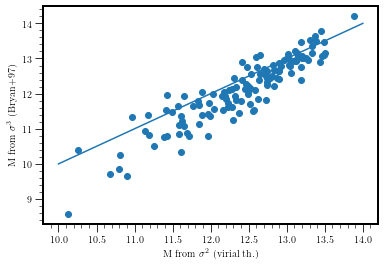

In [30]:
plt.scatter(np.log10(G_fof["Mvir_sigma2"]), np.log10(G_fof["Mvir_sigma3"]))
plt.plot([10,14], [10,14])
plt.xlabel("M from $\sigma^2$ (virial th.)")
plt.ylabel("M from $\sigma^3$ (Bryan+97)")

In [31]:
print("N of group of more than 3 galaxies: ", len(G3_fof))
print("N of group of more than 5 galaxies: ", len(G5_fof))

N of group of more than 3 galaxies:  131
N of group of more than 5 galaxies:  38


In [27]:
131-38

93

### Recompute the centers

For the centers we can just take the barycenters weighted by the stellar mass. With that method we don't have the drawback to choose arbitrarily a mass ratio threshold, so we don't have a sudden change of position under this value. In addition, we can estimate the error on the position of the center coming from the mass estimation.

To compute the error on the barycenter we need the error on the stellar mass. We have the lower and upper bound in the catalogs, we can take either the max of the diff between the bound and the central value, or the mean:

In [32]:
#R_fof["mass10_err"] = np.max(10**R_fof["mass"] - 10**R_fof["mass_l68"], 10**R_fof["mass_u68"] - 10**R_fof["mass"])
R_fof["mass10_err"] = (10**R_fof["mass"] - 10**R_fof["mass_l68"]) + (10**R_fof["mass_u68"] - 10**R_fof["mass"])

In [33]:
G_fof = gid.calc_mass_ratio(G_fof, R_fof)
G_fof = gid.recompute_centers_new(G_fof, R_fof)

/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:225: RuntimeWarning: invalid value encountered in double_scalars
  center_ra = (r["mass10"] * r["RA"]).sum() / (r["mass10"].sum())
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:226: RuntimeWarning: invalid value encountered in double_scalars
  center_dec = (r["mass10"] * r["DEC"]).sum() / (r["mass10"].sum())
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:227: RuntimeWarning: invalid value encountered in double_scalars
  center_z = (r["mass10"] * r["Z"]).sum() / (r["mass10"].sum())
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:225: RuntimeWarning: invalid value encountered in double_scalars
  center_ra = (r["mass10"] * r["RA"]).sum() / (r["mass10"].sum())
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:226: RuntimeWarning: invalid value encountered in double_scalars
  center_dec = (r["mass10"] * r["DEC"]).sum() / (r["mass10"].sum())
/home/mcherrey/ownCloud/git_group

/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:225: RuntimeWarning: invalid value encountered in double_scalars
  center_ra = (r["mass10"] * r["RA"]).sum() / (r["mass10"].sum())
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:226: RuntimeWarning: invalid value encountered in double_scalars
  center_dec = (r["mass10"] * r["DEC"]).sum() / (r["mass10"].sum())
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:227: RuntimeWarning: invalid value encountered in double_scalars
  center_z = (r["mass10"] * r["Z"]).sum() / (r["mass10"].sum())
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:225: RuntimeWarning: invalid value encountered in double_scalars
  center_ra = (r["mass10"] * r["RA"]).sum() / (r["mass10"].sum())
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:226: RuntimeWarning: invalid value encountered in double_scalars
  center_dec = (r["mass10"] * r["DEC"]).sum() / (r["mass10"].sum())
/home/mcherrey/ownCloud/git_group

/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:225: RuntimeWarning: invalid value encountered in double_scalars
  center_ra = (r["mass10"] * r["RA"]).sum() / (r["mass10"].sum())
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:226: RuntimeWarning: invalid value encountered in double_scalars
  center_dec = (r["mass10"] * r["DEC"]).sum() / (r["mass10"].sum())
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:227: RuntimeWarning: invalid value encountered in double_scalars
  center_z = (r["mass10"] * r["Z"]).sum() / (r["mass10"].sum())
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:225: RuntimeWarning: invalid value encountered in double_scalars
  center_ra = (r["mass10"] * r["RA"]).sum() / (r["mass10"].sum())
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:226: RuntimeWarning: invalid value encountered in double_scalars
  center_dec = (r["mass10"] * r["DEC"]).sum() / (r["mass10"].sum())
/home/mcherrey/ownCloud/git_group

/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:225: RuntimeWarning: invalid value encountered in double_scalars
  center_ra = (r["mass10"] * r["RA"]).sum() / (r["mass10"].sum())
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:226: RuntimeWarning: invalid value encountered in double_scalars
  center_dec = (r["mass10"] * r["DEC"]).sum() / (r["mass10"].sum())
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:227: RuntimeWarning: invalid value encountered in double_scalars
  center_z = (r["mass10"] * r["Z"]).sum() / (r["mass10"].sum())
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:225: RuntimeWarning: invalid value encountered in double_scalars
  center_ra = (r["mass10"] * r["RA"]).sum() / (r["mass10"].sum())
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:226: RuntimeWarning: invalid value encountered in double_scalars
  center_dec = (r["mass10"] * r["DEC"]).sum() / (r["mass10"].sum())
/home/mcherrey/ownCloud/git_group

/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:225: RuntimeWarning: invalid value encountered in double_scalars
  center_ra = (r["mass10"] * r["RA"]).sum() / (r["mass10"].sum())
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:226: RuntimeWarning: invalid value encountered in double_scalars
  center_dec = (r["mass10"] * r["DEC"]).sum() / (r["mass10"].sum())
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:227: RuntimeWarning: invalid value encountered in double_scalars
  center_z = (r["mass10"] * r["Z"]).sum() / (r["mass10"].sum())
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:225: RuntimeWarning: invalid value encountered in double_scalars
  center_ra = (r["mass10"] * r["RA"]).sum() / (r["mass10"].sum())
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:226: RuntimeWarning: invalid value encountered in double_scalars
  center_dec = (r["mass10"] * r["DEC"]).sum() / (r["mass10"].sum())
/home/mcherrey/ownCloud/git_group

/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:225: RuntimeWarning: invalid value encountered in double_scalars
  center_ra = (r["mass10"] * r["RA"]).sum() / (r["mass10"].sum())
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:226: RuntimeWarning: invalid value encountered in double_scalars
  center_dec = (r["mass10"] * r["DEC"]).sum() / (r["mass10"].sum())
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:227: RuntimeWarning: invalid value encountered in double_scalars
  center_z = (r["mass10"] * r["Z"]).sum() / (r["mass10"].sum())
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:225: RuntimeWarning: invalid value encountered in double_scalars
  center_ra = (r["mass10"] * r["RA"]).sum() / (r["mass10"].sum())
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:226: RuntimeWarning: invalid value encountered in double_scalars
  center_dec = (r["mass10"] * r["DEC"]).sum() / (r["mass10"].sum())
/home/mcherrey/ownCloud/git_group

/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:225: RuntimeWarning: invalid value encountered in double_scalars
  center_ra = (r["mass10"] * r["RA"]).sum() / (r["mass10"].sum())
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:226: RuntimeWarning: invalid value encountered in double_scalars
  center_dec = (r["mass10"] * r["DEC"]).sum() / (r["mass10"].sum())
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:227: RuntimeWarning: invalid value encountered in double_scalars
  center_z = (r["mass10"] * r["Z"]).sum() / (r["mass10"].sum())
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:225: RuntimeWarning: invalid value encountered in double_scalars
  center_ra = (r["mass10"] * r["RA"]).sum() / (r["mass10"].sum())
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:226: RuntimeWarning: invalid value encountered in double_scalars
  center_dec = (r["mass10"] * r["DEC"]).sum() / (r["mass10"].sum())
/home/mcherrey/ownCloud/git_group

/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:225: RuntimeWarning: invalid value encountered in double_scalars
  center_ra = (r["mass10"] * r["RA"]).sum() / (r["mass10"].sum())
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:226: RuntimeWarning: invalid value encountered in double_scalars
  center_dec = (r["mass10"] * r["DEC"]).sum() / (r["mass10"].sum())
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:227: RuntimeWarning: invalid value encountered in double_scalars
  center_z = (r["mass10"] * r["Z"]).sum() / (r["mass10"].sum())
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:225: RuntimeWarning: invalid value encountered in double_scalars
  center_ra = (r["mass10"] * r["RA"]).sum() / (r["mass10"].sum())
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:226: RuntimeWarning: invalid value encountered in double_scalars
  center_dec = (r["mass10"] * r["DEC"]).sum() / (r["mass10"].sum())
/home/mcherrey/ownCloud/git_group

/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:225: RuntimeWarning: invalid value encountered in double_scalars
  center_ra = (r["mass10"] * r["RA"]).sum() / (r["mass10"].sum())
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:226: RuntimeWarning: invalid value encountered in double_scalars
  center_dec = (r["mass10"] * r["DEC"]).sum() / (r["mass10"].sum())
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:227: RuntimeWarning: invalid value encountered in double_scalars
  center_z = (r["mass10"] * r["Z"]).sum() / (r["mass10"].sum())
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:225: RuntimeWarning: invalid value encountered in double_scalars
  center_ra = (r["mass10"] * r["RA"]).sum() / (r["mass10"].sum())
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:226: RuntimeWarning: invalid value encountered in double_scalars
  center_dec = (r["mass10"] * r["DEC"]).sum() / (r["mass10"].sum())
/home/mcherrey/ownCloud/git_group

/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:225: RuntimeWarning: invalid value encountered in double_scalars
  center_ra = (r["mass10"] * r["RA"]).sum() / (r["mass10"].sum())
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:226: RuntimeWarning: invalid value encountered in double_scalars
  center_dec = (r["mass10"] * r["DEC"]).sum() / (r["mass10"].sum())
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:227: RuntimeWarning: invalid value encountered in double_scalars
  center_z = (r["mass10"] * r["Z"]).sum() / (r["mass10"].sum())
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:225: RuntimeWarning: invalid value encountered in double_scalars
  center_ra = (r["mass10"] * r["RA"]).sum() / (r["mass10"].sum())
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:226: RuntimeWarning: invalid value encountered in double_scalars
  center_dec = (r["mass10"] * r["DEC"]).sum() / (r["mass10"].sum())
/home/mcherrey/ownCloud/git_group

/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:226: RuntimeWarning: invalid value encountered in double_scalars
  center_dec = (r["mass10"] * r["DEC"]).sum() / (r["mass10"].sum())
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:227: RuntimeWarning: invalid value encountered in double_scalars
  center_z = (r["mass10"] * r["Z"]).sum() / (r["mass10"].sum())
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:225: RuntimeWarning: invalid value encountered in double_scalars
  center_ra = (r["mass10"] * r["RA"]).sum() / (r["mass10"].sum())
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:226: RuntimeWarning: invalid value encountered in double_scalars
  center_dec = (r["mass10"] * r["DEC"]).sum() / (r["mass10"].sum())
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:227: RuntimeWarning: invalid value encountered in double_scalars
  center_z = (r["mass10"] * r["Z"]).sum() / (r["mass10"].sum())
/home/mcherrey/ownCloud/git_groups/

/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:225: RuntimeWarning: invalid value encountered in double_scalars
  center_ra = (r["mass10"] * r["RA"]).sum() / (r["mass10"].sum())
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:226: RuntimeWarning: invalid value encountered in double_scalars
  center_dec = (r["mass10"] * r["DEC"]).sum() / (r["mass10"].sum())
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:227: RuntimeWarning: invalid value encountered in double_scalars
  center_z = (r["mass10"] * r["Z"]).sum() / (r["mass10"].sum())
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:225: RuntimeWarning: invalid value encountered in double_scalars
  center_ra = (r["mass10"] * r["RA"]).sum() / (r["mass10"].sum())
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:226: RuntimeWarning: invalid value encountered in double_scalars
  center_dec = (r["mass10"] * r["DEC"]).sum() / (r["mass10"].sum())
/home/mcherrey/ownCloud/git_group

/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:225: RuntimeWarning: invalid value encountered in double_scalars
  center_ra = (r["mass10"] * r["RA"]).sum() / (r["mass10"].sum())
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:226: RuntimeWarning: invalid value encountered in double_scalars
  center_dec = (r["mass10"] * r["DEC"]).sum() / (r["mass10"].sum())
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:227: RuntimeWarning: invalid value encountered in double_scalars
  center_z = (r["mass10"] * r["Z"]).sum() / (r["mass10"].sum())
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:225: RuntimeWarning: invalid value encountered in double_scalars
  center_ra = (r["mass10"] * r["RA"]).sum() / (r["mass10"].sum())
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:226: RuntimeWarning: invalid value encountered in double_scalars
  center_dec = (r["mass10"] * r["DEC"]).sum() / (r["mass10"].sum())
/home/mcherrey/ownCloud/git_group

/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:225: RuntimeWarning: invalid value encountered in double_scalars
  center_ra = (r["mass10"] * r["RA"]).sum() / (r["mass10"].sum())
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:226: RuntimeWarning: invalid value encountered in double_scalars
  center_dec = (r["mass10"] * r["DEC"]).sum() / (r["mass10"].sum())
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:227: RuntimeWarning: invalid value encountered in double_scalars
  center_z = (r["mass10"] * r["Z"]).sum() / (r["mass10"].sum())
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:225: RuntimeWarning: invalid value encountered in double_scalars
  center_ra = (r["mass10"] * r["RA"]).sum() / (r["mass10"].sum())
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:226: RuntimeWarning: invalid value encountered in double_scalars
  center_dec = (r["mass10"] * r["DEC"]).sum() / (r["mass10"].sum())
/home/mcherrey/ownCloud/git_group

/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:225: RuntimeWarning: invalid value encountered in double_scalars
  center_ra = (r["mass10"] * r["RA"]).sum() / (r["mass10"].sum())
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:226: RuntimeWarning: invalid value encountered in double_scalars
  center_dec = (r["mass10"] * r["DEC"]).sum() / (r["mass10"].sum())
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:227: RuntimeWarning: invalid value encountered in double_scalars
  center_z = (r["mass10"] * r["Z"]).sum() / (r["mass10"].sum())
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:225: RuntimeWarning: invalid value encountered in double_scalars
  center_ra = (r["mass10"] * r["RA"]).sum() / (r["mass10"].sum())
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:226: RuntimeWarning: invalid value encountered in double_scalars
  center_dec = (r["mass10"] * r["DEC"]).sum() / (r["mass10"].sum())
/home/mcherrey/ownCloud/git_group

/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:225: RuntimeWarning: invalid value encountered in double_scalars
  center_ra = (r["mass10"] * r["RA"]).sum() / (r["mass10"].sum())
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:226: RuntimeWarning: invalid value encountered in double_scalars
  center_dec = (r["mass10"] * r["DEC"]).sum() / (r["mass10"].sum())
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:227: RuntimeWarning: invalid value encountered in double_scalars
  center_z = (r["mass10"] * r["Z"]).sum() / (r["mass10"].sum())
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:225: RuntimeWarning: invalid value encountered in double_scalars
  center_ra = (r["mass10"] * r["RA"]).sum() / (r["mass10"].sum())
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:226: RuntimeWarning: invalid value encountered in double_scalars
  center_dec = (r["mass10"] * r["DEC"]).sum() / (r["mass10"].sum())
/home/mcherrey/ownCloud/git_group

/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:225: RuntimeWarning: invalid value encountered in double_scalars
  center_ra = (r["mass10"] * r["RA"]).sum() / (r["mass10"].sum())
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:226: RuntimeWarning: invalid value encountered in double_scalars
  center_dec = (r["mass10"] * r["DEC"]).sum() / (r["mass10"].sum())
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:227: RuntimeWarning: invalid value encountered in double_scalars
  center_z = (r["mass10"] * r["Z"]).sum() / (r["mass10"].sum())
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:225: RuntimeWarning: invalid value encountered in double_scalars
  center_ra = (r["mass10"] * r["RA"]).sum() / (r["mass10"].sum())
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:226: RuntimeWarning: invalid value encountered in double_scalars
  center_dec = (r["mass10"] * r["DEC"]).sum() / (r["mass10"].sum())
/home/mcherrey/ownCloud/git_group

/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:225: RuntimeWarning: invalid value encountered in double_scalars
  center_ra = (r["mass10"] * r["RA"]).sum() / (r["mass10"].sum())
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:226: RuntimeWarning: invalid value encountered in double_scalars
  center_dec = (r["mass10"] * r["DEC"]).sum() / (r["mass10"].sum())
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:227: RuntimeWarning: invalid value encountered in double_scalars
  center_z = (r["mass10"] * r["Z"]).sum() / (r["mass10"].sum())
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:225: RuntimeWarning: invalid value encountered in double_scalars
  center_ra = (r["mass10"] * r["RA"]).sum() / (r["mass10"].sum())
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:226: RuntimeWarning: invalid value encountered in double_scalars
  center_dec = (r["mass10"] * r["DEC"]).sum() / (r["mass10"].sum())
/home/mcherrey/ownCloud/git_group

/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:225: RuntimeWarning: invalid value encountered in double_scalars
  center_ra = (r["mass10"] * r["RA"]).sum() / (r["mass10"].sum())
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:226: RuntimeWarning: invalid value encountered in double_scalars
  center_dec = (r["mass10"] * r["DEC"]).sum() / (r["mass10"].sum())
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:227: RuntimeWarning: invalid value encountered in double_scalars
  center_z = (r["mass10"] * r["Z"]).sum() / (r["mass10"].sum())
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:225: RuntimeWarning: invalid value encountered in double_scalars
  center_ra = (r["mass10"] * r["RA"]).sum() / (r["mass10"].sum())
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:226: RuntimeWarning: invalid value encountered in double_scalars
  center_dec = (r["mass10"] * r["DEC"]).sum() / (r["mass10"].sum())
/home/mcherrey/ownCloud/git_group

/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:225: RuntimeWarning: invalid value encountered in double_scalars
  center_ra = (r["mass10"] * r["RA"]).sum() / (r["mass10"].sum())
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:226: RuntimeWarning: invalid value encountered in double_scalars
  center_dec = (r["mass10"] * r["DEC"]).sum() / (r["mass10"].sum())
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:227: RuntimeWarning: invalid value encountered in double_scalars
  center_z = (r["mass10"] * r["Z"]).sum() / (r["mass10"].sum())
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:225: RuntimeWarning: invalid value encountered in double_scalars
  center_ra = (r["mass10"] * r["RA"]).sum() / (r["mass10"].sum())
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:226: RuntimeWarning: invalid value encountered in double_scalars
  center_dec = (r["mass10"] * r["DEC"]).sum() / (r["mass10"].sum())
/home/mcherrey/ownCloud/git_group

/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:225: RuntimeWarning: invalid value encountered in double_scalars
  center_ra = (r["mass10"] * r["RA"]).sum() / (r["mass10"].sum())
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:226: RuntimeWarning: invalid value encountered in double_scalars
  center_dec = (r["mass10"] * r["DEC"]).sum() / (r["mass10"].sum())
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:227: RuntimeWarning: invalid value encountered in double_scalars
  center_z = (r["mass10"] * r["Z"]).sum() / (r["mass10"].sum())
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:225: RuntimeWarning: invalid value encountered in double_scalars
  center_ra = (r["mass10"] * r["RA"]).sum() / (r["mass10"].sum())
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:226: RuntimeWarning: invalid value encountered in double_scalars
  center_dec = (r["mass10"] * r["DEC"]).sum() / (r["mass10"].sum())
/home/mcherrey/ownCloud/git_group

/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:225: RuntimeWarning: invalid value encountered in double_scalars
  center_ra = (r["mass10"] * r["RA"]).sum() / (r["mass10"].sum())
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:226: RuntimeWarning: invalid value encountered in double_scalars
  center_dec = (r["mass10"] * r["DEC"]).sum() / (r["mass10"].sum())
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:227: RuntimeWarning: invalid value encountered in double_scalars
  center_z = (r["mass10"] * r["Z"]).sum() / (r["mass10"].sum())
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:225: RuntimeWarning: invalid value encountered in double_scalars
  center_ra = (r["mass10"] * r["RA"]).sum() / (r["mass10"].sum())
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:226: RuntimeWarning: invalid value encountered in double_scalars
  center_dec = (r["mass10"] * r["DEC"]).sum() / (r["mass10"].sum())
/home/mcherrey/ownCloud/git_group

/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:225: RuntimeWarning: invalid value encountered in double_scalars
  center_ra = (r["mass10"] * r["RA"]).sum() / (r["mass10"].sum())
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:226: RuntimeWarning: invalid value encountered in double_scalars
  center_dec = (r["mass10"] * r["DEC"]).sum() / (r["mass10"].sum())
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:227: RuntimeWarning: invalid value encountered in double_scalars
  center_z = (r["mass10"] * r["Z"]).sum() / (r["mass10"].sum())
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:225: RuntimeWarning: invalid value encountered in double_scalars
  center_ra = (r["mass10"] * r["RA"]).sum() / (r["mass10"].sum())
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:226: RuntimeWarning: invalid value encountered in double_scalars
  center_dec = (r["mass10"] * r["DEC"]).sum() / (r["mass10"].sum())
/home/mcherrey/ownCloud/git_group

/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:225: RuntimeWarning: invalid value encountered in double_scalars
  center_ra = (r["mass10"] * r["RA"]).sum() / (r["mass10"].sum())
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:226: RuntimeWarning: invalid value encountered in double_scalars
  center_dec = (r["mass10"] * r["DEC"]).sum() / (r["mass10"].sum())
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:227: RuntimeWarning: invalid value encountered in double_scalars
  center_z = (r["mass10"] * r["Z"]).sum() / (r["mass10"].sum())
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:225: RuntimeWarning: invalid value encountered in double_scalars
  center_ra = (r["mass10"] * r["RA"]).sum() / (r["mass10"].sum())
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:226: RuntimeWarning: invalid value encountered in double_scalars
  center_dec = (r["mass10"] * r["DEC"]).sum() / (r["mass10"].sum())
/home/mcherrey/ownCloud/git_group

/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:225: RuntimeWarning: invalid value encountered in double_scalars
  center_ra = (r["mass10"] * r["RA"]).sum() / (r["mass10"].sum())
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:226: RuntimeWarning: invalid value encountered in double_scalars
  center_dec = (r["mass10"] * r["DEC"]).sum() / (r["mass10"].sum())
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:227: RuntimeWarning: invalid value encountered in double_scalars
  center_z = (r["mass10"] * r["Z"]).sum() / (r["mass10"].sum())
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:225: RuntimeWarning: invalid value encountered in double_scalars
  center_ra = (r["mass10"] * r["RA"]).sum() / (r["mass10"].sum())
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:226: RuntimeWarning: invalid value encountered in double_scalars
  center_dec = (r["mass10"] * r["DEC"]).sum() / (r["mass10"].sum())
/home/mcherrey/ownCloud/git_group

/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:225: RuntimeWarning: invalid value encountered in double_scalars
  center_ra = (r["mass10"] * r["RA"]).sum() / (r["mass10"].sum())
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:226: RuntimeWarning: invalid value encountered in double_scalars
  center_dec = (r["mass10"] * r["DEC"]).sum() / (r["mass10"].sum())
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:227: RuntimeWarning: invalid value encountered in double_scalars
  center_z = (r["mass10"] * r["Z"]).sum() / (r["mass10"].sum())
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:225: RuntimeWarning: invalid value encountered in double_scalars
  center_ra = (r["mass10"] * r["RA"]).sum() / (r["mass10"].sum())
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:226: RuntimeWarning: invalid value encountered in double_scalars
  center_dec = (r["mass10"] * r["DEC"]).sum() / (r["mass10"].sum())
/home/mcherrey/ownCloud/git_group

/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:225: RuntimeWarning: invalid value encountered in double_scalars
  center_ra = (r["mass10"] * r["RA"]).sum() / (r["mass10"].sum())
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:226: RuntimeWarning: invalid value encountered in double_scalars
  center_dec = (r["mass10"] * r["DEC"]).sum() / (r["mass10"].sum())
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:227: RuntimeWarning: invalid value encountered in double_scalars
  center_z = (r["mass10"] * r["Z"]).sum() / (r["mass10"].sum())
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:225: RuntimeWarning: invalid value encountered in double_scalars
  center_ra = (r["mass10"] * r["RA"]).sum() / (r["mass10"].sum())
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:226: RuntimeWarning: invalid value encountered in double_scalars
  center_dec = (r["mass10"] * r["DEC"]).sum() / (r["mass10"].sum())
/home/mcherrey/ownCloud/git_group

/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:225: RuntimeWarning: invalid value encountered in double_scalars
  center_ra = (r["mass10"] * r["RA"]).sum() / (r["mass10"].sum())
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:226: RuntimeWarning: invalid value encountered in double_scalars
  center_dec = (r["mass10"] * r["DEC"]).sum() / (r["mass10"].sum())
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:227: RuntimeWarning: invalid value encountered in double_scalars
  center_z = (r["mass10"] * r["Z"]).sum() / (r["mass10"].sum())
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:225: RuntimeWarning: invalid value encountered in double_scalars
  center_ra = (r["mass10"] * r["RA"]).sum() / (r["mass10"].sum())
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:226: RuntimeWarning: invalid value encountered in double_scalars
  center_dec = (r["mass10"] * r["DEC"]).sum() / (r["mass10"].sum())
/home/mcherrey/ownCloud/git_group

/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:225: RuntimeWarning: invalid value encountered in double_scalars
  center_ra = (r["mass10"] * r["RA"]).sum() / (r["mass10"].sum())
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:226: RuntimeWarning: invalid value encountered in double_scalars
  center_dec = (r["mass10"] * r["DEC"]).sum() / (r["mass10"].sum())
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:227: RuntimeWarning: invalid value encountered in double_scalars
  center_z = (r["mass10"] * r["Z"]).sum() / (r["mass10"].sum())
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:225: RuntimeWarning: invalid value encountered in double_scalars
  center_ra = (r["mass10"] * r["RA"]).sum() / (r["mass10"].sum())
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:226: RuntimeWarning: invalid value encountered in double_scalars
  center_dec = (r["mass10"] * r["DEC"]).sum() / (r["mass10"].sum())
/home/mcherrey/ownCloud/git_group

/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:225: RuntimeWarning: invalid value encountered in double_scalars
  center_ra = (r["mass10"] * r["RA"]).sum() / (r["mass10"].sum())
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:226: RuntimeWarning: invalid value encountered in double_scalars
  center_dec = (r["mass10"] * r["DEC"]).sum() / (r["mass10"].sum())
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:227: RuntimeWarning: invalid value encountered in double_scalars
  center_z = (r["mass10"] * r["Z"]).sum() / (r["mass10"].sum())
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:225: RuntimeWarning: invalid value encountered in double_scalars
  center_ra = (r["mass10"] * r["RA"]).sum() / (r["mass10"].sum())
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:226: RuntimeWarning: invalid value encountered in double_scalars
  center_dec = (r["mass10"] * r["DEC"]).sum() / (r["mass10"].sum())
/home/mcherrey/ownCloud/git_group

/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:225: RuntimeWarning: invalid value encountered in double_scalars
  center_ra = (r["mass10"] * r["RA"]).sum() / (r["mass10"].sum())
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:226: RuntimeWarning: invalid value encountered in double_scalars
  center_dec = (r["mass10"] * r["DEC"]).sum() / (r["mass10"].sum())
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:227: RuntimeWarning: invalid value encountered in double_scalars
  center_z = (r["mass10"] * r["Z"]).sum() / (r["mass10"].sum())
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:225: RuntimeWarning: invalid value encountered in double_scalars
  center_ra = (r["mass10"] * r["RA"]).sum() / (r["mass10"].sum())
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:226: RuntimeWarning: invalid value encountered in double_scalars
  center_dec = (r["mass10"] * r["DEC"]).sum() / (r["mass10"].sum())
/home/mcherrey/ownCloud/git_group

/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:225: RuntimeWarning: invalid value encountered in double_scalars
  center_ra = (r["mass10"] * r["RA"]).sum() / (r["mass10"].sum())
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:226: RuntimeWarning: invalid value encountered in double_scalars
  center_dec = (r["mass10"] * r["DEC"]).sum() / (r["mass10"].sum())
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:227: RuntimeWarning: invalid value encountered in double_scalars
  center_z = (r["mass10"] * r["Z"]).sum() / (r["mass10"].sum())
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:225: RuntimeWarning: invalid value encountered in double_scalars
  center_ra = (r["mass10"] * r["RA"]).sum() / (r["mass10"].sum())
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:226: RuntimeWarning: invalid value encountered in double_scalars
  center_dec = (r["mass10"] * r["DEC"]).sum() / (r["mass10"].sum())
/home/mcherrey/ownCloud/git_group

/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:225: RuntimeWarning: invalid value encountered in double_scalars
  center_ra = (r["mass10"] * r["RA"]).sum() / (r["mass10"].sum())
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:226: RuntimeWarning: invalid value encountered in double_scalars
  center_dec = (r["mass10"] * r["DEC"]).sum() / (r["mass10"].sum())
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:227: RuntimeWarning: invalid value encountered in double_scalars
  center_z = (r["mass10"] * r["Z"]).sum() / (r["mass10"].sum())
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:225: RuntimeWarning: invalid value encountered in double_scalars
  center_ra = (r["mass10"] * r["RA"]).sum() / (r["mass10"].sum())
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:226: RuntimeWarning: invalid value encountered in double_scalars
  center_dec = (r["mass10"] * r["DEC"]).sum() / (r["mass10"].sum())
/home/mcherrey/ownCloud/git_group

/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:225: RuntimeWarning: invalid value encountered in double_scalars
  center_ra = (r["mass10"] * r["RA"]).sum() / (r["mass10"].sum())
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:226: RuntimeWarning: invalid value encountered in double_scalars
  center_dec = (r["mass10"] * r["DEC"]).sum() / (r["mass10"].sum())
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:227: RuntimeWarning: invalid value encountered in double_scalars
  center_z = (r["mass10"] * r["Z"]).sum() / (r["mass10"].sum())
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:225: RuntimeWarning: invalid value encountered in double_scalars
  center_ra = (r["mass10"] * r["RA"]).sum() / (r["mass10"].sum())
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:226: RuntimeWarning: invalid value encountered in double_scalars
  center_dec = (r["mass10"] * r["DEC"]).sum() / (r["mass10"].sum())
/home/mcherrey/ownCloud/git_group

/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:225: RuntimeWarning: invalid value encountered in double_scalars
  center_ra = (r["mass10"] * r["RA"]).sum() / (r["mass10"].sum())
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:226: RuntimeWarning: invalid value encountered in double_scalars
  center_dec = (r["mass10"] * r["DEC"]).sum() / (r["mass10"].sum())
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:227: RuntimeWarning: invalid value encountered in double_scalars
  center_z = (r["mass10"] * r["Z"]).sum() / (r["mass10"].sum())
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:225: RuntimeWarning: invalid value encountered in double_scalars
  center_ra = (r["mass10"] * r["RA"]).sum() / (r["mass10"].sum())
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:226: RuntimeWarning: invalid value encountered in double_scalars
  center_dec = (r["mass10"] * r["DEC"]).sum() / (r["mass10"].sum())
/home/mcherrey/ownCloud/git_group

/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:225: RuntimeWarning: invalid value encountered in double_scalars
  center_ra = (r["mass10"] * r["RA"]).sum() / (r["mass10"].sum())
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:226: RuntimeWarning: invalid value encountered in double_scalars
  center_dec = (r["mass10"] * r["DEC"]).sum() / (r["mass10"].sum())
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:227: RuntimeWarning: invalid value encountered in double_scalars
  center_z = (r["mass10"] * r["Z"]).sum() / (r["mass10"].sum())
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:225: RuntimeWarning: invalid value encountered in double_scalars
  center_ra = (r["mass10"] * r["RA"]).sum() / (r["mass10"].sum())
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:226: RuntimeWarning: invalid value encountered in double_scalars
  center_dec = (r["mass10"] * r["DEC"]).sum() / (r["mass10"].sum())
/home/mcherrey/ownCloud/git_group

### Match with QSO

In [34]:
R_fof = gid.match_qso(R_fof, fields_info)
G_fof = gid.match_qso(G_fof, fields_info)
len(G_fof["group_id"])

1362

In [35]:
f1 = G_fof["Mvir_sigma2"]>=1e12
f2 = G_fof["Mvir_sigma2"]>=1e13
f3 = G_fof["mean_z"]>=0.3
f4 = G_fof["mean_z"]<=1.5
print("Number of groups with mass above 1e12 Msun: ", len(G_fof[f1 & f3 & f4]))
print("Number of groups with mass above 1e13 Msun: ", len(G_fof[f2 & f3 & f4]))

Number of groups with mass above 1e12 Msun:  77
Number of groups with mass above 1e13 Msun:  27


# II. Refinement with Halo occupation method (Hom)

In [36]:
G_hom = G_fof.copy()
R_hom = R_fof.copy()

In [37]:
#G_hom, R_hom = gid.hod_refinement_2(G_hom, R_hom)

In [38]:
#R_hom.to_csv("R_hom_raw_v17.csv", index = False)
#G_hom.to_csv("G_hom_raw_v17.csv", index = False)
R_hom = pd.read_csv("R_hom_raw_v17.csv", index_col = False)
G_hom = pd.read_csv("G_hom_raw_v17.csv", index_col = False)

In [39]:
print(len(R_hom))
print(len(G_hom))

2018
1362


In [40]:
G_hom = G_hom.sort_values(by="N_gal", ascending = False)
G_hom.head()

field_id  group_id  N_gal    mean_z     mean_ra   mean_dec  b_min_kpc  \
1324  J1039p0714       605     21  0.987775  159.902073   7.241364      46.37   
1325  J0145p1056       842     21  0.937542   26.304750  10.938249       1.28   
1326  J0014m0028      1274     15  0.830293    3.719997  -0.477257       7.77   
1327  J1107p1021       544     14  0.744204  166.927830  10.357167      36.59   
1328  J0058p0111      1065     11  0.637828   14.733676   1.190410       6.04   

       Mvir_sigma2   Mvir_sigma3  Rvir_sigma2  ...  Comments_qso  zqso_sdss  \
1324  7.630926e+12  4.314044e+12   309.353476  ...           NaN      1.532   
1325  1.542607e+13  2.944945e+13   400.005144  ...           NaN      0.938   
1326  7.592986e+13  1.590934e+14   714.677895  ...           NaN      1.927   
1327  1.271862e+13  1.686994e+13   410.352121  ...           NaN      1.925   
1328  1.369761e+13  1.447540e+13   443.105829  ...           NaN      1.222   

      depth_qso  ebv_sfd_qso  ebv_sandf_qso  ebv_planck_qso  HST_qso  \
1324       24.5       0.0402         0.0346        0.049340     None   
1325       24.5       0.0677         0.0582        0.064520     None   
1326       25.0       0.0529         0.0455        0.061763     None   
1327       24.5       0.0262         0.0225        0.031879     WFC3   
1328       24.5       0.0253         0.0218        0.029647     None   

      rmag_qso      ra_qso    dec_qso  
1324       NaN  159.902785   7.240934  
1325       NaN   26.304623  10.940742  
1326       NaN    3.722351  -0.474349  
1327      17.6  166.928091  10.357311  
1328       NaN   14.732323   1.191270  

[5 rows x 38 columns]

Now we would like to reobtain the group catalog. The problem is that the "outlier" column is from the caustic method. And to obtain the group we need that outliers = the galaxies with a low Psat. Let's do that:

In [41]:
R_hom["outlier"] = R_hom["Psat"].apply(lambda x : not bool(np.round(x)))

In [42]:
R_hom[["Psat", "outlier"]]

Psat  outlier
0          NaN    False
1          NaN    False
2          NaN    False
3          NaN    False
4          NaN    False
...        ...      ...
2013  0.995316    False
2014  0.994718    False
2015  0.993620    False
2016  0.987401    False
2017  0.975059    False

[2018 rows x 2 columns]

In [43]:
G_final = gid.get_groups(R_hom, N_min = 1)
G3_final = gid.get_groups(R_hom, N_min = 3)
G5_final = gid.get_groups(R_hom, N_min = 5)
len(G_final)

1362

In [44]:
G_final = gid.calc_mass_ratio(G_final, R_hom)
G_final = gid.recompute_centers_new(G_final, R_hom)

/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:225: RuntimeWarning: invalid value encountered in double_scalars
  center_ra = (r["mass10"] * r["RA"]).sum() / (r["mass10"].sum())
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:226: RuntimeWarning: invalid value encountered in double_scalars
  center_dec = (r["mass10"] * r["DEC"]).sum() / (r["mass10"].sum())
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:227: RuntimeWarning: invalid value encountered in double_scalars
  center_z = (r["mass10"] * r["Z"]).sum() / (r["mass10"].sum())
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:225: RuntimeWarning: invalid value encountered in double_scalars
  center_ra = (r["mass10"] * r["RA"]).sum() / (r["mass10"].sum())
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:226: RuntimeWarning: invalid value encountered in double_scalars
  center_dec = (r["mass10"] * r["DEC"]).sum() / (r["mass10"].sum())
/home/mcherrey/ownCloud/git_group

/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:225: RuntimeWarning: invalid value encountered in double_scalars
  center_ra = (r["mass10"] * r["RA"]).sum() / (r["mass10"].sum())
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:226: RuntimeWarning: invalid value encountered in double_scalars
  center_dec = (r["mass10"] * r["DEC"]).sum() / (r["mass10"].sum())
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:227: RuntimeWarning: invalid value encountered in double_scalars
  center_z = (r["mass10"] * r["Z"]).sum() / (r["mass10"].sum())
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:225: RuntimeWarning: invalid value encountered in double_scalars
  center_ra = (r["mass10"] * r["RA"]).sum() / (r["mass10"].sum())
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:226: RuntimeWarning: invalid value encountered in double_scalars
  center_dec = (r["mass10"] * r["DEC"]).sum() / (r["mass10"].sum())
/home/mcherrey/ownCloud/git_group

/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:225: RuntimeWarning: invalid value encountered in double_scalars
  center_ra = (r["mass10"] * r["RA"]).sum() / (r["mass10"].sum())
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:226: RuntimeWarning: invalid value encountered in double_scalars
  center_dec = (r["mass10"] * r["DEC"]).sum() / (r["mass10"].sum())
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:227: RuntimeWarning: invalid value encountered in double_scalars
  center_z = (r["mass10"] * r["Z"]).sum() / (r["mass10"].sum())
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:225: RuntimeWarning: invalid value encountered in double_scalars
  center_ra = (r["mass10"] * r["RA"]).sum() / (r["mass10"].sum())
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:226: RuntimeWarning: invalid value encountered in double_scalars
  center_dec = (r["mass10"] * r["DEC"]).sum() / (r["mass10"].sum())
/home/mcherrey/ownCloud/git_group

/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:225: RuntimeWarning: invalid value encountered in double_scalars
  center_ra = (r["mass10"] * r["RA"]).sum() / (r["mass10"].sum())
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:226: RuntimeWarning: invalid value encountered in double_scalars
  center_dec = (r["mass10"] * r["DEC"]).sum() / (r["mass10"].sum())
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:227: RuntimeWarning: invalid value encountered in double_scalars
  center_z = (r["mass10"] * r["Z"]).sum() / (r["mass10"].sum())
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:225: RuntimeWarning: invalid value encountered in double_scalars
  center_ra = (r["mass10"] * r["RA"]).sum() / (r["mass10"].sum())
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:226: RuntimeWarning: invalid value encountered in double_scalars
  center_dec = (r["mass10"] * r["DEC"]).sum() / (r["mass10"].sum())
/home/mcherrey/ownCloud/git_group

/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:225: RuntimeWarning: invalid value encountered in double_scalars
  center_ra = (r["mass10"] * r["RA"]).sum() / (r["mass10"].sum())
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:226: RuntimeWarning: invalid value encountered in double_scalars
  center_dec = (r["mass10"] * r["DEC"]).sum() / (r["mass10"].sum())
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:227: RuntimeWarning: invalid value encountered in double_scalars
  center_z = (r["mass10"] * r["Z"]).sum() / (r["mass10"].sum())
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:225: RuntimeWarning: invalid value encountered in double_scalars
  center_ra = (r["mass10"] * r["RA"]).sum() / (r["mass10"].sum())
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:226: RuntimeWarning: invalid value encountered in double_scalars
  center_dec = (r["mass10"] * r["DEC"]).sum() / (r["mass10"].sum())
/home/mcherrey/ownCloud/git_group

/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:225: RuntimeWarning: invalid value encountered in double_scalars
  center_ra = (r["mass10"] * r["RA"]).sum() / (r["mass10"].sum())
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:226: RuntimeWarning: invalid value encountered in double_scalars
  center_dec = (r["mass10"] * r["DEC"]).sum() / (r["mass10"].sum())
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:227: RuntimeWarning: invalid value encountered in double_scalars
  center_z = (r["mass10"] * r["Z"]).sum() / (r["mass10"].sum())
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:225: RuntimeWarning: invalid value encountered in double_scalars
  center_ra = (r["mass10"] * r["RA"]).sum() / (r["mass10"].sum())
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:226: RuntimeWarning: invalid value encountered in double_scalars
  center_dec = (r["mass10"] * r["DEC"]).sum() / (r["mass10"].sum())
/home/mcherrey/ownCloud/git_group

/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:225: RuntimeWarning: invalid value encountered in double_scalars
  center_ra = (r["mass10"] * r["RA"]).sum() / (r["mass10"].sum())
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:226: RuntimeWarning: invalid value encountered in double_scalars
  center_dec = (r["mass10"] * r["DEC"]).sum() / (r["mass10"].sum())
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:227: RuntimeWarning: invalid value encountered in double_scalars
  center_z = (r["mass10"] * r["Z"]).sum() / (r["mass10"].sum())
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:225: RuntimeWarning: invalid value encountered in double_scalars
  center_ra = (r["mass10"] * r["RA"]).sum() / (r["mass10"].sum())
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:226: RuntimeWarning: invalid value encountered in double_scalars
  center_dec = (r["mass10"] * r["DEC"]).sum() / (r["mass10"].sum())
/home/mcherrey/ownCloud/git_group

/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:225: RuntimeWarning: invalid value encountered in double_scalars
  center_ra = (r["mass10"] * r["RA"]).sum() / (r["mass10"].sum())
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:226: RuntimeWarning: invalid value encountered in double_scalars
  center_dec = (r["mass10"] * r["DEC"]).sum() / (r["mass10"].sum())
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:227: RuntimeWarning: invalid value encountered in double_scalars
  center_z = (r["mass10"] * r["Z"]).sum() / (r["mass10"].sum())
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:225: RuntimeWarning: invalid value encountered in double_scalars
  center_ra = (r["mass10"] * r["RA"]).sum() / (r["mass10"].sum())
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:226: RuntimeWarning: invalid value encountered in double_scalars
  center_dec = (r["mass10"] * r["DEC"]).sum() / (r["mass10"].sum())
/home/mcherrey/ownCloud/git_group

/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:225: RuntimeWarning: invalid value encountered in double_scalars
  center_ra = (r["mass10"] * r["RA"]).sum() / (r["mass10"].sum())
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:226: RuntimeWarning: invalid value encountered in double_scalars
  center_dec = (r["mass10"] * r["DEC"]).sum() / (r["mass10"].sum())
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:227: RuntimeWarning: invalid value encountered in double_scalars
  center_z = (r["mass10"] * r["Z"]).sum() / (r["mass10"].sum())
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:225: RuntimeWarning: invalid value encountered in double_scalars
  center_ra = (r["mass10"] * r["RA"]).sum() / (r["mass10"].sum())
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:226: RuntimeWarning: invalid value encountered in double_scalars
  center_dec = (r["mass10"] * r["DEC"]).sum() / (r["mass10"].sum())
/home/mcherrey/ownCloud/git_group

/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:225: RuntimeWarning: invalid value encountered in double_scalars
  center_ra = (r["mass10"] * r["RA"]).sum() / (r["mass10"].sum())
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:226: RuntimeWarning: invalid value encountered in double_scalars
  center_dec = (r["mass10"] * r["DEC"]).sum() / (r["mass10"].sum())
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:227: RuntimeWarning: invalid value encountered in double_scalars
  center_z = (r["mass10"] * r["Z"]).sum() / (r["mass10"].sum())
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:225: RuntimeWarning: invalid value encountered in double_scalars
  center_ra = (r["mass10"] * r["RA"]).sum() / (r["mass10"].sum())
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:226: RuntimeWarning: invalid value encountered in double_scalars
  center_dec = (r["mass10"] * r["DEC"]).sum() / (r["mass10"].sum())
/home/mcherrey/ownCloud/git_group

/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:225: RuntimeWarning: invalid value encountered in double_scalars
  center_ra = (r["mass10"] * r["RA"]).sum() / (r["mass10"].sum())
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:226: RuntimeWarning: invalid value encountered in double_scalars
  center_dec = (r["mass10"] * r["DEC"]).sum() / (r["mass10"].sum())
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:227: RuntimeWarning: invalid value encountered in double_scalars
  center_z = (r["mass10"] * r["Z"]).sum() / (r["mass10"].sum())
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:225: RuntimeWarning: invalid value encountered in double_scalars
  center_ra = (r["mass10"] * r["RA"]).sum() / (r["mass10"].sum())
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:226: RuntimeWarning: invalid value encountered in double_scalars
  center_dec = (r["mass10"] * r["DEC"]).sum() / (r["mass10"].sum())
/home/mcherrey/ownCloud/git_group

/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:225: RuntimeWarning: invalid value encountered in double_scalars
  center_ra = (r["mass10"] * r["RA"]).sum() / (r["mass10"].sum())
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:226: RuntimeWarning: invalid value encountered in double_scalars
  center_dec = (r["mass10"] * r["DEC"]).sum() / (r["mass10"].sum())
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:227: RuntimeWarning: invalid value encountered in double_scalars
  center_z = (r["mass10"] * r["Z"]).sum() / (r["mass10"].sum())
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:225: RuntimeWarning: invalid value encountered in double_scalars
  center_ra = (r["mass10"] * r["RA"]).sum() / (r["mass10"].sum())
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:226: RuntimeWarning: invalid value encountered in double_scalars
  center_dec = (r["mass10"] * r["DEC"]).sum() / (r["mass10"].sum())
/home/mcherrey/ownCloud/git_group

/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:225: RuntimeWarning: invalid value encountered in double_scalars
  center_ra = (r["mass10"] * r["RA"]).sum() / (r["mass10"].sum())
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:226: RuntimeWarning: invalid value encountered in double_scalars
  center_dec = (r["mass10"] * r["DEC"]).sum() / (r["mass10"].sum())
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:227: RuntimeWarning: invalid value encountered in double_scalars
  center_z = (r["mass10"] * r["Z"]).sum() / (r["mass10"].sum())
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:225: RuntimeWarning: invalid value encountered in double_scalars
  center_ra = (r["mass10"] * r["RA"]).sum() / (r["mass10"].sum())
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:226: RuntimeWarning: invalid value encountered in double_scalars
  center_dec = (r["mass10"] * r["DEC"]).sum() / (r["mass10"].sum())
/home/mcherrey/ownCloud/git_group

/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:225: RuntimeWarning: invalid value encountered in double_scalars
  center_ra = (r["mass10"] * r["RA"]).sum() / (r["mass10"].sum())
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:226: RuntimeWarning: invalid value encountered in double_scalars
  center_dec = (r["mass10"] * r["DEC"]).sum() / (r["mass10"].sum())
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:227: RuntimeWarning: invalid value encountered in double_scalars
  center_z = (r["mass10"] * r["Z"]).sum() / (r["mass10"].sum())
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:225: RuntimeWarning: invalid value encountered in double_scalars
  center_ra = (r["mass10"] * r["RA"]).sum() / (r["mass10"].sum())
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:226: RuntimeWarning: invalid value encountered in double_scalars
  center_dec = (r["mass10"] * r["DEC"]).sum() / (r["mass10"].sum())
/home/mcherrey/ownCloud/git_group

/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:225: RuntimeWarning: invalid value encountered in double_scalars
  center_ra = (r["mass10"] * r["RA"]).sum() / (r["mass10"].sum())
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:226: RuntimeWarning: invalid value encountered in double_scalars
  center_dec = (r["mass10"] * r["DEC"]).sum() / (r["mass10"].sum())
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:227: RuntimeWarning: invalid value encountered in double_scalars
  center_z = (r["mass10"] * r["Z"]).sum() / (r["mass10"].sum())
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:225: RuntimeWarning: invalid value encountered in double_scalars
  center_ra = (r["mass10"] * r["RA"]).sum() / (r["mass10"].sum())
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:226: RuntimeWarning: invalid value encountered in double_scalars
  center_dec = (r["mass10"] * r["DEC"]).sum() / (r["mass10"].sum())
/home/mcherrey/ownCloud/git_group

/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:225: RuntimeWarning: invalid value encountered in double_scalars
  center_ra = (r["mass10"] * r["RA"]).sum() / (r["mass10"].sum())
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:226: RuntimeWarning: invalid value encountered in double_scalars
  center_dec = (r["mass10"] * r["DEC"]).sum() / (r["mass10"].sum())
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:227: RuntimeWarning: invalid value encountered in double_scalars
  center_z = (r["mass10"] * r["Z"]).sum() / (r["mass10"].sum())
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:225: RuntimeWarning: invalid value encountered in double_scalars
  center_ra = (r["mass10"] * r["RA"]).sum() / (r["mass10"].sum())
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:226: RuntimeWarning: invalid value encountered in double_scalars
  center_dec = (r["mass10"] * r["DEC"]).sum() / (r["mass10"].sum())
/home/mcherrey/ownCloud/git_group

/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:225: RuntimeWarning: invalid value encountered in double_scalars
  center_ra = (r["mass10"] * r["RA"]).sum() / (r["mass10"].sum())
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:226: RuntimeWarning: invalid value encountered in double_scalars
  center_dec = (r["mass10"] * r["DEC"]).sum() / (r["mass10"].sum())
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:227: RuntimeWarning: invalid value encountered in double_scalars
  center_z = (r["mass10"] * r["Z"]).sum() / (r["mass10"].sum())
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:225: RuntimeWarning: invalid value encountered in double_scalars
  center_ra = (r["mass10"] * r["RA"]).sum() / (r["mass10"].sum())
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:226: RuntimeWarning: invalid value encountered in double_scalars
  center_dec = (r["mass10"] * r["DEC"]).sum() / (r["mass10"].sum())
/home/mcherrey/ownCloud/git_group

/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:225: RuntimeWarning: invalid value encountered in double_scalars
  center_ra = (r["mass10"] * r["RA"]).sum() / (r["mass10"].sum())
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:226: RuntimeWarning: invalid value encountered in double_scalars
  center_dec = (r["mass10"] * r["DEC"]).sum() / (r["mass10"].sum())
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:227: RuntimeWarning: invalid value encountered in double_scalars
  center_z = (r["mass10"] * r["Z"]).sum() / (r["mass10"].sum())
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:225: RuntimeWarning: invalid value encountered in double_scalars
  center_ra = (r["mass10"] * r["RA"]).sum() / (r["mass10"].sum())
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:226: RuntimeWarning: invalid value encountered in double_scalars
  center_dec = (r["mass10"] * r["DEC"]).sum() / (r["mass10"].sum())
/home/mcherrey/ownCloud/git_group

/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:225: RuntimeWarning: invalid value encountered in double_scalars
  center_ra = (r["mass10"] * r["RA"]).sum() / (r["mass10"].sum())
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:226: RuntimeWarning: invalid value encountered in double_scalars
  center_dec = (r["mass10"] * r["DEC"]).sum() / (r["mass10"].sum())
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:227: RuntimeWarning: invalid value encountered in double_scalars
  center_z = (r["mass10"] * r["Z"]).sum() / (r["mass10"].sum())
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:225: RuntimeWarning: invalid value encountered in double_scalars
  center_ra = (r["mass10"] * r["RA"]).sum() / (r["mass10"].sum())
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:226: RuntimeWarning: invalid value encountered in double_scalars
  center_dec = (r["mass10"] * r["DEC"]).sum() / (r["mass10"].sum())
/home/mcherrey/ownCloud/git_group

/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:225: RuntimeWarning: invalid value encountered in double_scalars
  center_ra = (r["mass10"] * r["RA"]).sum() / (r["mass10"].sum())
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:226: RuntimeWarning: invalid value encountered in double_scalars
  center_dec = (r["mass10"] * r["DEC"]).sum() / (r["mass10"].sum())
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:227: RuntimeWarning: invalid value encountered in double_scalars
  center_z = (r["mass10"] * r["Z"]).sum() / (r["mass10"].sum())
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:225: RuntimeWarning: invalid value encountered in double_scalars
  center_ra = (r["mass10"] * r["RA"]).sum() / (r["mass10"].sum())
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:226: RuntimeWarning: invalid value encountered in double_scalars
  center_dec = (r["mass10"] * r["DEC"]).sum() / (r["mass10"].sum())
/home/mcherrey/ownCloud/git_group

/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:225: RuntimeWarning: invalid value encountered in double_scalars
  center_ra = (r["mass10"] * r["RA"]).sum() / (r["mass10"].sum())
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:226: RuntimeWarning: invalid value encountered in double_scalars
  center_dec = (r["mass10"] * r["DEC"]).sum() / (r["mass10"].sum())
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:227: RuntimeWarning: invalid value encountered in double_scalars
  center_z = (r["mass10"] * r["Z"]).sum() / (r["mass10"].sum())
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:225: RuntimeWarning: invalid value encountered in double_scalars
  center_ra = (r["mass10"] * r["RA"]).sum() / (r["mass10"].sum())
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:226: RuntimeWarning: invalid value encountered in double_scalars
  center_dec = (r["mass10"] * r["DEC"]).sum() / (r["mass10"].sum())
/home/mcherrey/ownCloud/git_group

/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:225: RuntimeWarning: invalid value encountered in double_scalars
  center_ra = (r["mass10"] * r["RA"]).sum() / (r["mass10"].sum())
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:226: RuntimeWarning: invalid value encountered in double_scalars
  center_dec = (r["mass10"] * r["DEC"]).sum() / (r["mass10"].sum())
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:227: RuntimeWarning: invalid value encountered in double_scalars
  center_z = (r["mass10"] * r["Z"]).sum() / (r["mass10"].sum())
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:225: RuntimeWarning: invalid value encountered in double_scalars
  center_ra = (r["mass10"] * r["RA"]).sum() / (r["mass10"].sum())
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:226: RuntimeWarning: invalid value encountered in double_scalars
  center_dec = (r["mass10"] * r["DEC"]).sum() / (r["mass10"].sum())
/home/mcherrey/ownCloud/git_group

/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:225: RuntimeWarning: invalid value encountered in double_scalars
  center_ra = (r["mass10"] * r["RA"]).sum() / (r["mass10"].sum())
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:226: RuntimeWarning: invalid value encountered in double_scalars
  center_dec = (r["mass10"] * r["DEC"]).sum() / (r["mass10"].sum())
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:227: RuntimeWarning: invalid value encountered in double_scalars
  center_z = (r["mass10"] * r["Z"]).sum() / (r["mass10"].sum())
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:225: RuntimeWarning: invalid value encountered in double_scalars
  center_ra = (r["mass10"] * r["RA"]).sum() / (r["mass10"].sum())
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:226: RuntimeWarning: invalid value encountered in double_scalars
  center_dec = (r["mass10"] * r["DEC"]).sum() / (r["mass10"].sum())
/home/mcherrey/ownCloud/git_group

/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:225: RuntimeWarning: invalid value encountered in double_scalars
  center_ra = (r["mass10"] * r["RA"]).sum() / (r["mass10"].sum())
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:226: RuntimeWarning: invalid value encountered in double_scalars
  center_dec = (r["mass10"] * r["DEC"]).sum() / (r["mass10"].sum())
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:227: RuntimeWarning: invalid value encountered in double_scalars
  center_z = (r["mass10"] * r["Z"]).sum() / (r["mass10"].sum())
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:225: RuntimeWarning: invalid value encountered in double_scalars
  center_ra = (r["mass10"] * r["RA"]).sum() / (r["mass10"].sum())
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:226: RuntimeWarning: invalid value encountered in double_scalars
  center_dec = (r["mass10"] * r["DEC"]).sum() / (r["mass10"].sum())
/home/mcherrey/ownCloud/git_group

/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:225: RuntimeWarning: invalid value encountered in double_scalars
  center_ra = (r["mass10"] * r["RA"]).sum() / (r["mass10"].sum())
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:226: RuntimeWarning: invalid value encountered in double_scalars
  center_dec = (r["mass10"] * r["DEC"]).sum() / (r["mass10"].sum())
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:227: RuntimeWarning: invalid value encountered in double_scalars
  center_z = (r["mass10"] * r["Z"]).sum() / (r["mass10"].sum())
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:225: RuntimeWarning: invalid value encountered in double_scalars
  center_ra = (r["mass10"] * r["RA"]).sum() / (r["mass10"].sum())
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:226: RuntimeWarning: invalid value encountered in double_scalars
  center_dec = (r["mass10"] * r["DEC"]).sum() / (r["mass10"].sum())
/home/mcherrey/ownCloud/git_group

/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:225: RuntimeWarning: invalid value encountered in double_scalars
  center_ra = (r["mass10"] * r["RA"]).sum() / (r["mass10"].sum())
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:226: RuntimeWarning: invalid value encountered in double_scalars
  center_dec = (r["mass10"] * r["DEC"]).sum() / (r["mass10"].sum())
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:227: RuntimeWarning: invalid value encountered in double_scalars
  center_z = (r["mass10"] * r["Z"]).sum() / (r["mass10"].sum())
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:225: RuntimeWarning: invalid value encountered in double_scalars
  center_ra = (r["mass10"] * r["RA"]).sum() / (r["mass10"].sum())
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:226: RuntimeWarning: invalid value encountered in double_scalars
  center_dec = (r["mass10"] * r["DEC"]).sum() / (r["mass10"].sum())
/home/mcherrey/ownCloud/git_group

/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:225: RuntimeWarning: invalid value encountered in double_scalars
  center_ra = (r["mass10"] * r["RA"]).sum() / (r["mass10"].sum())
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:226: RuntimeWarning: invalid value encountered in double_scalars
  center_dec = (r["mass10"] * r["DEC"]).sum() / (r["mass10"].sum())
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:227: RuntimeWarning: invalid value encountered in double_scalars
  center_z = (r["mass10"] * r["Z"]).sum() / (r["mass10"].sum())
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:225: RuntimeWarning: invalid value encountered in double_scalars
  center_ra = (r["mass10"] * r["RA"]).sum() / (r["mass10"].sum())
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:226: RuntimeWarning: invalid value encountered in double_scalars
  center_dec = (r["mass10"] * r["DEC"]).sum() / (r["mass10"].sum())
/home/mcherrey/ownCloud/git_group

/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:225: RuntimeWarning: invalid value encountered in double_scalars
  center_ra = (r["mass10"] * r["RA"]).sum() / (r["mass10"].sum())
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:226: RuntimeWarning: invalid value encountered in double_scalars
  center_dec = (r["mass10"] * r["DEC"]).sum() / (r["mass10"].sum())
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:227: RuntimeWarning: invalid value encountered in double_scalars
  center_z = (r["mass10"] * r["Z"]).sum() / (r["mass10"].sum())
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:225: RuntimeWarning: invalid value encountered in double_scalars
  center_ra = (r["mass10"] * r["RA"]).sum() / (r["mass10"].sum())
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:226: RuntimeWarning: invalid value encountered in double_scalars
  center_dec = (r["mass10"] * r["DEC"]).sum() / (r["mass10"].sum())
/home/mcherrey/ownCloud/git_group

/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:225: RuntimeWarning: invalid value encountered in double_scalars
  center_ra = (r["mass10"] * r["RA"]).sum() / (r["mass10"].sum())
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:226: RuntimeWarning: invalid value encountered in double_scalars
  center_dec = (r["mass10"] * r["DEC"]).sum() / (r["mass10"].sum())
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:227: RuntimeWarning: invalid value encountered in double_scalars
  center_z = (r["mass10"] * r["Z"]).sum() / (r["mass10"].sum())
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:225: RuntimeWarning: invalid value encountered in double_scalars
  center_ra = (r["mass10"] * r["RA"]).sum() / (r["mass10"].sum())
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:226: RuntimeWarning: invalid value encountered in double_scalars
  center_dec = (r["mass10"] * r["DEC"]).sum() / (r["mass10"].sum())
/home/mcherrey/ownCloud/git_group

/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:225: RuntimeWarning: invalid value encountered in double_scalars
  center_ra = (r["mass10"] * r["RA"]).sum() / (r["mass10"].sum())
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:226: RuntimeWarning: invalid value encountered in double_scalars
  center_dec = (r["mass10"] * r["DEC"]).sum() / (r["mass10"].sum())
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:227: RuntimeWarning: invalid value encountered in double_scalars
  center_z = (r["mass10"] * r["Z"]).sum() / (r["mass10"].sum())
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:225: RuntimeWarning: invalid value encountered in double_scalars
  center_ra = (r["mass10"] * r["RA"]).sum() / (r["mass10"].sum())
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:226: RuntimeWarning: invalid value encountered in double_scalars
  center_dec = (r["mass10"] * r["DEC"]).sum() / (r["mass10"].sum())
/home/mcherrey/ownCloud/git_group

/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:225: RuntimeWarning: invalid value encountered in double_scalars
  center_ra = (r["mass10"] * r["RA"]).sum() / (r["mass10"].sum())
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:226: RuntimeWarning: invalid value encountered in double_scalars
  center_dec = (r["mass10"] * r["DEC"]).sum() / (r["mass10"].sum())
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:227: RuntimeWarning: invalid value encountered in double_scalars
  center_z = (r["mass10"] * r["Z"]).sum() / (r["mass10"].sum())
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:225: RuntimeWarning: invalid value encountered in double_scalars
  center_ra = (r["mass10"] * r["RA"]).sum() / (r["mass10"].sum())
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:226: RuntimeWarning: invalid value encountered in double_scalars
  center_dec = (r["mass10"] * r["DEC"]).sum() / (r["mass10"].sum())
/home/mcherrey/ownCloud/git_group

/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:225: RuntimeWarning: invalid value encountered in double_scalars
  center_ra = (r["mass10"] * r["RA"]).sum() / (r["mass10"].sum())
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:226: RuntimeWarning: invalid value encountered in double_scalars
  center_dec = (r["mass10"] * r["DEC"]).sum() / (r["mass10"].sum())
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:227: RuntimeWarning: invalid value encountered in double_scalars
  center_z = (r["mass10"] * r["Z"]).sum() / (r["mass10"].sum())
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:225: RuntimeWarning: invalid value encountered in double_scalars
  center_ra = (r["mass10"] * r["RA"]).sum() / (r["mass10"].sum())
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:226: RuntimeWarning: invalid value encountered in double_scalars
  center_dec = (r["mass10"] * r["DEC"]).sum() / (r["mass10"].sum())
/home/mcherrey/ownCloud/git_group

/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:225: RuntimeWarning: invalid value encountered in double_scalars
  center_ra = (r["mass10"] * r["RA"]).sum() / (r["mass10"].sum())
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:226: RuntimeWarning: invalid value encountered in double_scalars
  center_dec = (r["mass10"] * r["DEC"]).sum() / (r["mass10"].sum())
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:227: RuntimeWarning: invalid value encountered in double_scalars
  center_z = (r["mass10"] * r["Z"]).sum() / (r["mass10"].sum())
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:225: RuntimeWarning: invalid value encountered in double_scalars
  center_ra = (r["mass10"] * r["RA"]).sum() / (r["mass10"].sum())
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:226: RuntimeWarning: invalid value encountered in double_scalars
  center_dec = (r["mass10"] * r["DEC"]).sum() / (r["mass10"].sum())
/home/mcherrey/ownCloud/git_group

/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:225: RuntimeWarning: invalid value encountered in double_scalars
  center_ra = (r["mass10"] * r["RA"]).sum() / (r["mass10"].sum())
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:226: RuntimeWarning: invalid value encountered in double_scalars
  center_dec = (r["mass10"] * r["DEC"]).sum() / (r["mass10"].sum())
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:227: RuntimeWarning: invalid value encountered in double_scalars
  center_z = (r["mass10"] * r["Z"]).sum() / (r["mass10"].sum())
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:225: RuntimeWarning: invalid value encountered in double_scalars
  center_ra = (r["mass10"] * r["RA"]).sum() / (r["mass10"].sum())
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:226: RuntimeWarning: invalid value encountered in double_scalars
  center_dec = (r["mass10"] * r["DEC"]).sum() / (r["mass10"].sum())
/home/mcherrey/ownCloud/git_group

In [45]:
R_final, G_final = gid.calc_mass(R_hom, G_final, N_lim = 3)

/home/mcherrey/anaconda3/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Text(0, 0.5, 'M from $\\sigma^3$ (Bryan+97)')

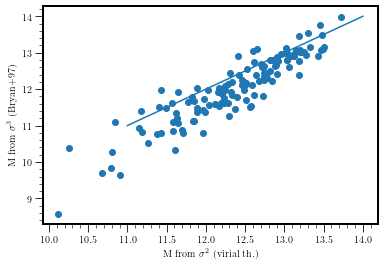

In [46]:
plt.scatter(np.log10(G_final["Mvir_sigma2"]), np.log10(G_final["Mvir_sigma3"]))
plt.plot([11,14],[11,14])
plt.xlabel("M from $\sigma^2$ (virial th.)")
plt.ylabel("M from $\sigma^3$ (Bryan+97)")

In [47]:
print("N of group of more than 3 galaxies: ", len(G3_final))
print("N of group of more than 5 galaxies: ", len(G5_final))

N of group of more than 3 galaxies:  130
N of group of more than 5 galaxies:  32


In [48]:
R_final = gid.match_qso(R_final, fields_info)

In [49]:
G_final = gid.create_id(G_final, "N_gal")

In [50]:
f1 = G_final["Mvir_sigma2"]>=1e12
f2 = G_final["Mvir_sigma2"]>=1e13
f3 = G_final["center_z"]>=0.3
f4 = G_final["center_z"]<=1.5
print("Number of groups with mass above 1e12 Msun: ", len(G_final[f1 & f3 & f4]))
print("Number of groups with mass above 1e13 Msun: ", len(G_final[f2 & f3 & f4]))

Number of groups with mass above 1e12 Msun:  73
Number of groups with mass above 1e13 Msun:  21


In [51]:
G_final.columns

Index(['index', 'field_id', 'group_id', 'N_gal', 'mean_z', 'mean_ra',
       'mean_dec', 'b_min_kpc', 'Mvir_sigma2', 'Mvir_sigma3', 'Rvir_sigma2',
       'Rvir_sigma3', 'Mstar', 'm1_m2_ratio', 'center_ra', 'center_dec',
       'center_z', 'center_ra_err', 'center_dec_err', 'center_z_err',
       'Mvir_sigma2_error', 'Rvir_sigma2_error', 'Mvir_sigma3_error',
       'Rvir_sigma3_error', 'Rmax', 'sigma_v', 'sigma_v_error', 'ID'],
      dtype='object')

In [52]:
G_final = gid.match_qso(G_final, fields_info)
len(G_final["group_id"])

1362

### N galaxies in xxx kpc

In [53]:
G_final = gid.get_Nxxx_all_groups(R_final, G_final, radius = 100)
G_final = gid.get_Nxxx_all_groups(R_final, G_final, radius = 200)

### Nb of galaxies around the LOS

In [54]:
N100 = []
dv = 1e6
for i, r in R_final.iterrows():
    f1 = np.abs(R_final["Z"] - r["Z"])*const.c.value/(1+r["Z"])<dv
    f2 = R_final["field_id"] == r["field_id"]
    f3 = R_final["B_KPC"]<100
    F = R_final[f1 & f2 & f3]
    N100.append(len(F))
R_final["N100_los"] = np.array(N100)

In [55]:
G_final = gid.get_N100_LOS(G_final, R_final, dv = 1e6)

### Nb of neighb for each galaxy

In [56]:
R_final = gid.get_Nxxx_neighb(R_final, radius = 100)
R_final = gid.get_Nxxx_neighb(R_final, radius = 50)

### Impact parameter relatively to the center of the groups

In [57]:
ra0 = G_final["center_ra"]*u.degree
ra1 = G_final["mean_ra"]*u.degree
ra2 = G_final["ra_qso"]*u.degree
dec0 = G_final["center_dec"]*u.degree
dec1 = G_final["mean_dec"]*u.degree
dec2 = G_final["dec_qso"]*u.degree
c0 = SkyCoord(ra0, dec0)
c1 = SkyCoord(ra1, dec1)
c2 = SkyCoord(ra2, dec2)
sep0 = c0.separation(c2)
sep1 = c1.separation(c2)
G_final["dist"] = Distance(unit=u.kpc, z = G_final["center_z"]).value/((1+G_final["center_z"])**2)
G_final["b_center_kpc"] = sep0.radian*G_final["dist"]
G_final["b_geomcenter_kpc"] = sep1.radian*G_final["dist"]
G_final = G_final.astype({"b_center_kpc":"float"})
G_final = G_final.astype({"b_geomcenter_kpc":"float"})

### Impact parameters normalized by Rvir:

In [58]:
G_final = gid.b_center_error(G_final)

In [59]:
G_final["b_min_kpc_norm2"] = G_final["b_min_kpc"]/G_final["Rvir_sigma2"] 
G_final["b_center_kpc_norm2"] = G_final["b_center_kpc"]/G_final["Rvir_sigma2"] 
G_final["b_geomcenter_kpc_norm2"] = G_final["b_geomcenter_kpc"]/G_final["Rvir_sigma2"]

G_final["b_min_kpc_norm2_err"] =  G_final["b_min_kpc_norm2"] * G_final["Rvir_sigma2_error"]/G_final["Rvir_sigma2"] 
G_final["b_center_kpc_norm2_err"] = G_final["b_center_err"]/G_final["Rvir_sigma2"] + G_final["b_center_kpc_norm2"] * G_final["Rvir_sigma2_error"]/G_final["Rvir_sigma2"] 
G_final["b_geomcenter_kpc_norm2_err"] = G_final["b_geomcenter_kpc_norm2"]* G_final["Rvir_sigma2_error"]/G_final["Rvir_sigma2"]

G_final["b_min_kpc_norm3"] = G_final["b_min_kpc"]/G_final["Rvir_sigma3"] 
G_final["b_center_kpc_norm3"] = G_final["b_center_kpc"]/G_final["Rvir_sigma3"] 
G_final["b_geomcenter_kpc_norm3"] = G_final["b_geomcenter_kpc"]/G_final["Rvir_sigma3"]

G_final["b_min_kpc_norm3_err"] = G_final["b_min_kpc_norm3"] * G_final["Rvir_sigma3_error"]/G_final["Rvir_sigma3"] 
G_final["b_center_kpc_norm3_err"] = G_final["b_center_err"]/G_final["Rvir_sigma2"] + G_final["b_center_kpc_norm3"] * G_final["Rvir_sigma3_error"]/G_final["Rvir_sigma3"] 
G_final["b_geomcenter_kpc_norm3_err"] = G_final["b_geomcenter_kpc_norm3"]* G_final["Rvir_sigma3_error"]/G_final["Rvir_sigma3"]


### check if QSO is behind the groups

In [60]:
G_final["QSO_is_behind"] = G_final["mean_z"] <= G_final["zqso_sdss"] - 3e6/const.c.value

In [61]:
len(G_final[G_final["QSO_is_behind"] == True])

709

### Detection limit

In [62]:
R_final["detection_limit"] = 0.1/(1+R_final["Z"])
G_final["detection_limit"] = 0.1/(1+G_final["center_z"])

### absorption & emission expected lamba

In [63]:
G_final["lambda_oii_a"] = oii_a*(1+G_final["mean_z"])
G_final["lambda_oii_b"] = oii_b*(1+G_final["mean_z"])
G_final["lambda_mgii_a"] = mgii_a*(1+G_final["mean_z"])
G_final["lambda_mgii_b"] = mgii_b*(1+G_final["mean_z"])


R_final["lambda_oii_a"] = oii_a*(1+R_final["Z"])
R_final["lambda_oii_b"] = oii_b*(1+R_final["Z"])
R_final["lambda_mgii_a"] = mgii_a*(1+R_final["Z"])
R_final["lambda_mgii_b"] = mgii_b*(1+R_final["Z"])

### Match with absorptions:

In [64]:
Abs = gid.get_N100_abs(Abs, R_final, dv = 0.5e6)
Abs2 = gid.get_Nxxx_abs(Abs, R_final, bmax = 2000, dv = 0.5e6)
Abs3 = gid.get_Nxxx_abs_test(Abs, R_final, bmax = 100, dv = 0.5e6)
Abs4 = gid.get_Nxxx_abs_test(Abs, R_final, bmax = 2000, dv = 0.5e6)

N100_mean:  1.1428571428571428


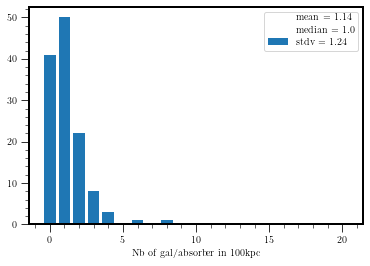

In [65]:
mean = np.mean(Abs["N100_abs"])
med = np.median(Abs["N100_abs"])
stdv = np.std(Abs["N100_abs"])
label = "mean = " + str(np.round(mean,2)) +\
        "\n median = "+ str(np.round(med,2)) +\
        "\n stdv = "+ str(np.round(stdv,2))
plt.hist(Abs["N100_abs"], range = (-0.5,20.5), bins = 21, rwidth = 0.8, label = label);
plt.xlabel("Nb of gal/absorber in 100kpc")
plt.legend()
print("N100_mean: ",np.mean(Abs["N100_abs"]))

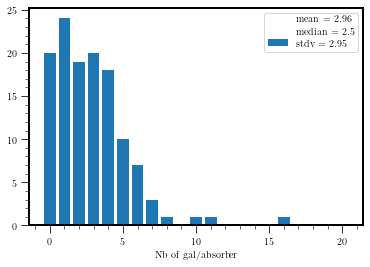

In [66]:
mean = np.mean(Abs2["N2000_abs"])
med = np.median(Abs2["N2000_abs"])
stdv = np.std(Abs2["N2000_abs"])
label = "mean = " + str(np.round(mean,2)) +\
        "\n median = "+ str(np.round(med,2)) +\
        "\n stdv = "+ str(np.round(stdv,2))
plt.hist(Abs2["N2000_abs"], range = (-0.5,20.5), bins = 21, rwidth = 0.8, label = label);
plt.xlabel("Nb of gal/absorber")
plt.legend()

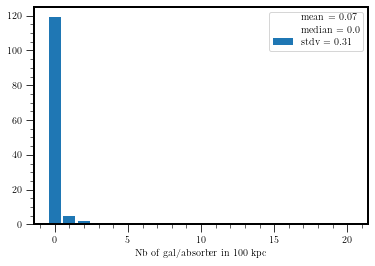

In [67]:
mean = np.mean(Abs["N100_abs_random"])
med = np.median(Abs["N100_abs_random"])
stdv = np.std(Abs["N100_abs_random"])
label = "mean = " + str(np.round(mean,2)) +\
        "\n median = "+ str(np.round(med,2)) +\
        "\n stdv = "+ str(np.round(stdv,2))
plt.hist(Abs3["N100_abs_random"], range = (-0.5,20.5), bins = 21, rwidth = 0.8, label = label);
plt.xlabel("Nb of gal/absorber in 100 kpc")
plt.legend()

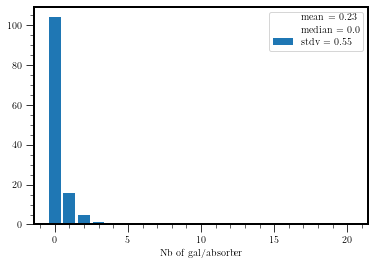

In [68]:
mean = np.mean(Abs["N2000_abs_random"])
med = np.median(Abs["N2000_abs_random"])
stdv = np.std(Abs["N2000_abs_random"])
label = "mean = " + str(np.round(mean,2)) +\
        "\n median = "+ str(np.round(med,2)) +\
        "\n stdv = "+ str(np.round(stdv,2))
plt.hist(Abs4["N2000_abs_random"], range = (-0.5,20.5), bins = 21, rwidth = 0.8, label = label);
plt.xlabel("Nb of gal/absorber")
plt.legend()

In [69]:
G_final = gid.match_absorptions(G_final, Abs, dv = 1e6)
R_final = gid.match_absorptions_isolated_galaxies(R_final, Abs, dv = 0.5e6)

### Filtering UVES coverage

In [70]:
cov_table = pd.read_csv("group_abs_coverage_table.csv")

In [71]:
dz = 0.5e6/const.c.value
grp_id = []
for i, c in cov_table.iterrows():
    f = c["field_id"]
    z = c["mean_z"]
    k1 = G_final["field_id"] == f
    k2 = G_final["mean_z"].between(z-dz, z+dz)
    match = G_final[k1 & k2]
    if len(match) == 1:
        grp_id.append(float(match["group_id"].values))
    else:
        grp_id.append(-1)
    #print(len(match))
cov_table["group_id"] = np.array(grp_id)

In [72]:
cov_table_trunc = cov_table[["group_id","FeII_2374_lim", "FeII_2600_lim", "MgII_2796_lim", "MgII_2803_lim", "MgI_2852_lim"]]

In [73]:
cov_table_trunc.drop_duplicates(subset ="group_id",keep = False, inplace = True)

In [74]:
G_final = G_final.merge(cov_table_trunc, on = "group_id", how = "left")

# Errors estimation

There are several sources of uncertainties to take into account.

The error bars for MgII EW are quite small.
The error bars for Mvir and Rvir are much more important.

Several things must be taken into account:
1. Rvir is computed from $\sigma^2$ or $\sigma^3$. The error on sigma comes from the sampling. The more we have galaxies, the better is the sampling. Assuming that velocities are normally distributed, the 1-σ uncertainty on $\sigma$ for a group of n galaxies is the standard error on the standard deviation on velocities and is equal to: $\sigma_{los} \sqrt{1 − c_4^2(n)}$ where $c_4(n) \approx 1-1/4n - 7/32n^2 - 19/128n^3$. For this component there is no bias.
2. Rvir is also computed from the visually estimated radius. This estimation is wrong because the FOV could crop the group. If we note L the half of the size of the FOV (here 30 arcsec), and if we consider a group of real radius R, there is an underestimation in $(2L)^2 - (2(L-R))^2$ cases upon a total of $(2L)^2$ cases. And the average underestimation is (if we except the case of the corners) $\approx \frac{R^2(2L-R)}{L^2}$. Of course it would be possible to refine this number for each group by considering the distance between its center and the LOS. For this source of error we have a bias toward lower values (it tends to underestimate Rvir)
3. The less galaxies we have in a group, the more we underestimate the radius of the group. This uncertainty can be estimated by a MC method (see in the dedicated notebook)
4. We consider the heaviest galaxy as the center of the group. What if it is not the case? Very difficult to estimate.... Could measure on TNG the distance between the central galaxy and DM halo center..

Maybe points 3 and 4 could be merged and resolved if we use the spatial dispersion to estimate the radius of the group.

In [75]:
print("N of group of more than 3 galaxies: ", len(G3_final))
print("N of group of more than 5 galaxies: ", len(G5_final))

N of group of more than 3 galaxies:  130
N of group of more than 5 galaxies:  32


In [76]:
G = G_final.copy()
R = R_final.copy()

f5 = G["N_gal"] == 1
f6 = G["N_gal"]  > 1
f7 = G["N100_los"] > 1
f8 = G["bool_absorption"] == 1
f9 = G["N_gal"] >= 5
f99 = G["N_gal"] >= 3
f10 = G["bool_absorption"] == 0
f11 = G["N_gal"] >= 2
f12 = G["MgII_2796_lim"] == np.inf
f13 = G["MgII_2796_lim"] != np.inf
f14 = G["QSO_is_behind"] == True
#f24 = G["ID"].isin(good_grp)

f15 = R["B_KPC"] <= 100
f16 = R["N100_los"] <= 2
f17 = R["N100_los"] <= 1
f18 = R["N50_neighb"] == 0
f19 = R["Z"] >= 4700/2796 - 1
f20 = R["Z"] <= 9300/2796 - 1
f21 = R["bool_absorption"] == 0
f22 = R["bool_absorption"] == 1
f23 = R["B_KPC"]>= 5 # remove the QSOs
#fweirds = G["Rvir_recomputed"] >= 10

In [77]:
G_abs = G[f8 & f14 & f13]
G_noabs = G[f10 & f14 & f13]
G2 = G[f7 & f13 & f14]
G2_abs = G[f8 & f7 & f14 & f13]
G2_noabs = G[f10 & f7 & f14 & f13]
G5 = G[f9 & f13 & f14]
#G5 = gid.create_id(G5, "N_gal")
G5_abs = G5[G5["bool_absorption"] == 1]
G5_noabs = G5[G5["bool_absorption"] == 0]
G3 = G[f99 & f13 & f14]
G3_abs = G3[G3["bool_absorption"] == 1]
G3_noabs = G3[G3["bool_absorption"] == 0]

R_ilane_abs = R[f22 & f15 & f17 & f18 & f23]
R_ilane_noabs = R[f21 & f15 & f17 & f18  & f23]
R_ilane2_abs = R[f22 & f17 & f18  & f23]
R_ilane2_noabs = R[f21 & f17 & f18  & f23]

In [78]:
print("nb of groups of more than 3 gal: ", len(G3))
print("nb of groups of more than 5 gal: ", len(G5))

nb of groups of more than 3 gal:  94
nb of groups of more than 5 gal:  26


# Some plots about our group sample

(10.0, 15.0)

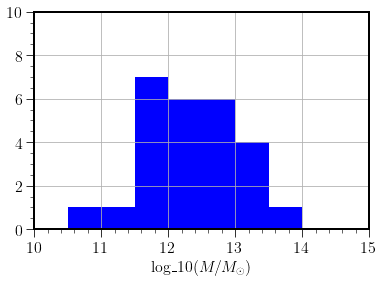

In [97]:
plt.hist(np.log10(G5["Mvir_sigma2"]), bins = 9, range = (10,14.5), color = 'blue');
plt.xlabel("log_{10}($M/M_{\odot}$)")
plt.grid()
plt.ylim((0,10))
plt.xlim((10,15))

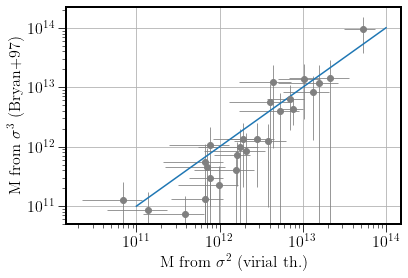

In [98]:
plt.errorbar(G5["Mvir_sigma2"], G5["Mvir_sigma3"], xerr = G5["Mvir_sigma2_error"], yerr = G5["Mvir_sigma3_error"],\
            fmt = 'o', c = "gray", linewidth = 0.8)
plt.plot([1e11,1e14],[1e11,1e14])
plt.xlabel("M from $\sigma^2$ (virial th.)")
plt.ylabel("M from $\sigma^3$ (Bryan+97)")
plt.xscale("log")
plt.yscale("log")
plt.grid()

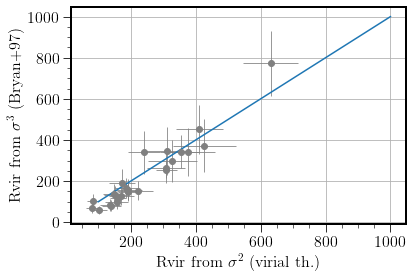

In [99]:
plt.errorbar(G5["Rvir_sigma2"], G5["Rvir_sigma3"], xerr = G5["Rvir_sigma2_error"], yerr = G5["Rvir_sigma3_error"],\
            fmt = 'o', c = "gray", linewidth = 0.8)
plt.plot([100,1000],[100,1000])
plt.xlabel("Rvir from $\sigma^2$ (virial th.)")
plt.ylabel("Rvir from $\sigma^3$ (Bryan+97)")
plt.grid()

In [100]:
G5_noabs["b_center_kpc_norm2_err"]

5     0.213089
9     0.324718
18    0.173621
28    0.151341
30    0.487209
Name: b_center_kpc_norm2_err, dtype: float64

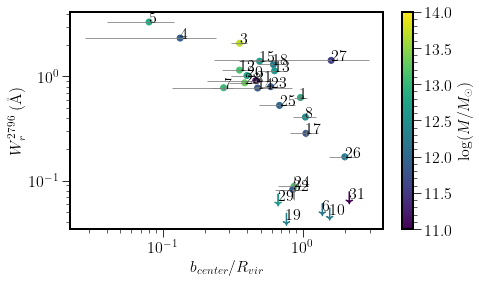

In [101]:
plt.figure(figsize = (7,4))
#plt.title("FoF groups ($N >= 5$)")
plt.errorbar(G5_abs["b_center_kpc_norm2"], G5_abs["REW_2796"], xerr = G5_abs["b_center_kpc_norm2_err"], yerr = G5_abs["sig_REW_2796"],\
             fmt = 'none',c = "gray", linewidth = 0.8)
plt.scatter(G5_abs["b_center_kpc_norm2"], G5_abs["REW_2796"], marker = "o", label = "groups N >= 5", \
            c = np.log10(G5_abs["Mvir_sigma2"]), vmin = 11, vmax = 14)
plt.colorbar(label = "log($M/M_{\odot}$)")
plt.errorbar(G5_noabs["b_center_kpc_norm2"], G5_noabs["REW_2796"], xerr = G5_noabs["b_center_kpc_norm2_err"], yerr = G5_noabs["sig_REW_2796"],\
             fmt = 'none',c = "gray", linewidth = 0.8)
plt.scatter(G5_noabs["b_center_kpc_norm2"], G5_noabs["detection_limit"], marker = "$\downarrow$", s = 150,\
            label = "groups N >= 5", c = np.log10(G5_noabs["Mvir_sigma2"]),vmin = 11, vmax = 14)

X = np.array(G5_abs["b_center_kpc_norm2"])
Y = np.array(G5_abs["REW_2796"])
txt = np.array(G5_abs["ID"])

for i in range(len(G5_abs)):
    plt.annotate(str(txt[i]), (X[i], Y[i]))
    
X = np.array(G5_noabs["b_center_kpc_norm2"])
Y = np.array(G5_noabs["detection_limit"])
txt = np.array(G5_noabs["ID"])

for i in range(len(G5_noabs)):
    plt.annotate(str(txt[i]), (X[i], Y[i]))


plt.xlabel("$b_{center}/R_{vir}$")
plt.ylabel("$W_r^{2796}$ (\AA)")
#plt.grid()
plt.xscale("log")
plt.yscale("log")
#plt.xlim((0.1,5))

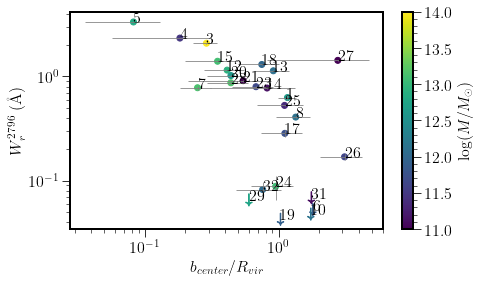

In [102]:
plt.figure(figsize = (7,4))
#plt.title("FoF groups ($N >= 5$)")
plt.errorbar(G5_abs["b_center_kpc_norm3"], G5_abs["REW_2796"], xerr = G5_abs["b_center_kpc_norm3_err"], yerr = G5_abs["sig_REW_2796"],\
             fmt = 'none',c = "gray", linewidth = 0.8)
plt.scatter(G5_abs["b_center_kpc_norm3"], G5_abs["REW_2796"], marker = "o", label = "groups N >= 5", \
            c = np.log10(G5_abs["Mvir_sigma3"]), vmin = 11, vmax = 14)
plt.colorbar(label = "log($M/M_{\odot}$)")
plt.errorbar(G5_noabs["b_center_kpc_norm3"], G5_noabs["REW_2796"], xerr = G5_noabs["b_center_kpc_norm3_err"], yerr = G5_noabs["sig_REW_2796"],\
             fmt = 'none',c = "gray", linewidth = 0.8)
plt.scatter(G5_noabs["b_center_kpc_norm3"], G5_noabs["detection_limit"], marker = "$\downarrow$", s = 150,\
            label = "groups N >= 5", c = np.log10(G5_noabs["Mvir_sigma3"]),vmin = 11, vmax = 14)

X = np.array(G5_abs["b_center_kpc_norm3"])
Y = np.array(G5_abs["REW_2796"])
txt = np.array(G5_abs["ID"])

for i in range(len(G5_abs)):
    plt.annotate(str(txt[i]), (X[i], Y[i]))
    
X = np.array(G5_noabs["b_center_kpc_norm3"])
Y = np.array(G5_noabs["detection_limit"])
txt = np.array(G5_noabs["ID"])

for i in range(len(G5_noabs)):
    plt.annotate(str(txt[i]), (X[i], Y[i]))


plt.xlabel("$b_{center}/R_{vir}$")
plt.ylabel("$W_r^{2796}$ (\AA)")
#plt.grid()
plt.xscale("log")
plt.yscale("log")
#plt.xlim((0.1,5))

In [104]:
# the ids of the groups are:
id_list = G5["group_id"].to_list()
R5 = R[R["group_id"].isin(id_list)]
len(R5)

193

In [105]:
len(R5[R5["outlier"] == False])

182

# Exports

In [91]:
R_final.to_csv("R_final_17.csv", index = False)
G_final.to_csv("G_final_17.csv", index = False)

In [85]:
#G5["m1_m2_ratio"] >= 1.5

In [86]:
def calc_mass_ratio(G, R):
    G["m1_m2_ratio"] = -1
    for i, g in G.iterrows():
        r = R[R["group_id"] == g["group_id"]]
        r = r.sort_values(by="mass10", ascending = False)
        r = r[r["mass"].isna() == False]
        #print(r["mass"])
        if len(r) >= 2:
            r0 = r[:1]
            r1 = r[1:2]
            r0 = r0.squeeze()
            r1 = r1.squeeze()
            ratio = (10**r0["mass"])/(10**r1["mass"])
            #print("----------------------- RATIO = ", ratio)
            plt.figure()
            plt.suptitle("RATIO = " +str(np.round(ratio,3)))
            plt.scatter([1,2], [r0["mass10"], r1["mass10"]])
            plt.vlines([1,2], [10**r0["mass_l68"], 10**r1["mass_l68"]],[10**r0["mass_u68"],10**r1["mass_u68"]],\
                       color ="gray", linewidth = 0.8)
            plt.xlim((0,3))
            #plt.ylim((1e9,5e11))
            plt.yscale("log")
    return

<ipython-input-86-665022e81908>:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


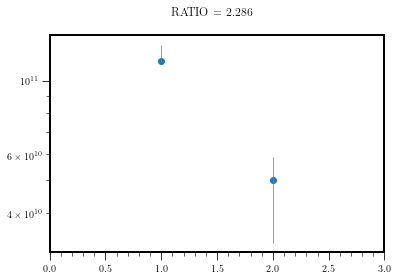

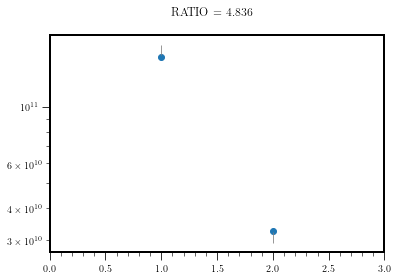

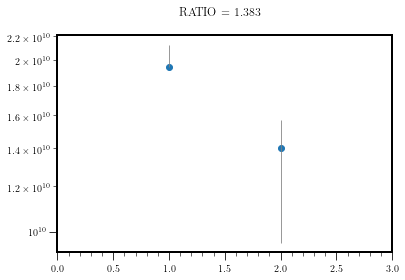

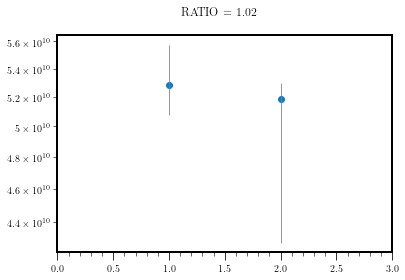

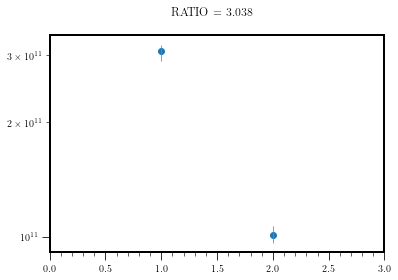

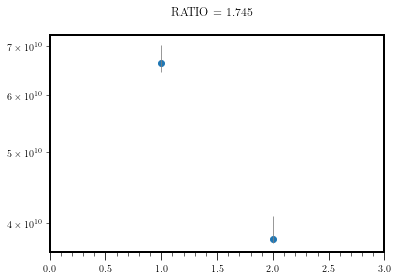

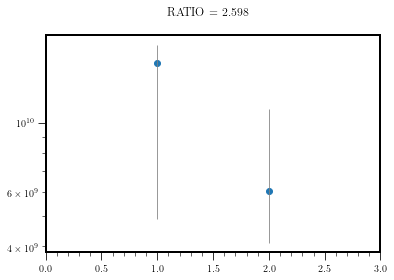

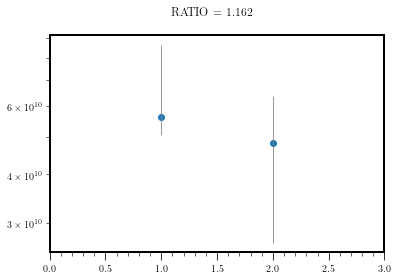

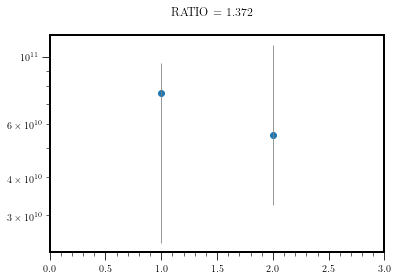

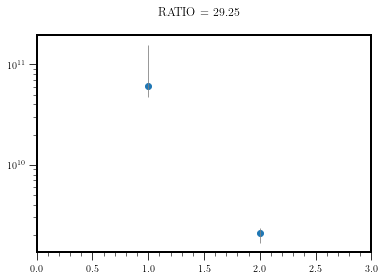

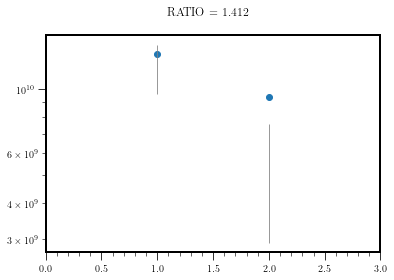

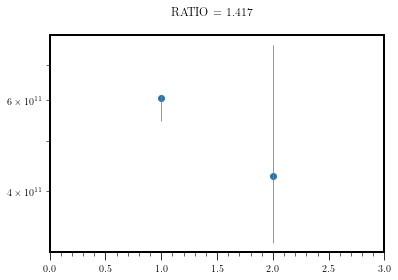

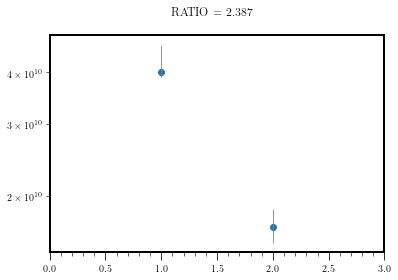

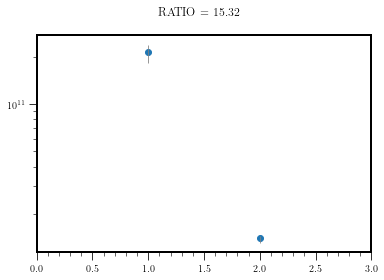

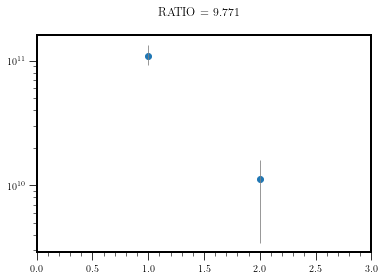

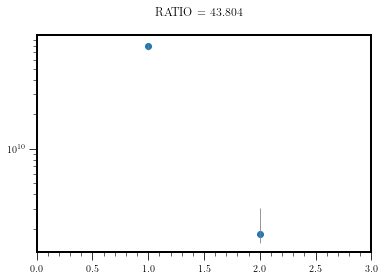

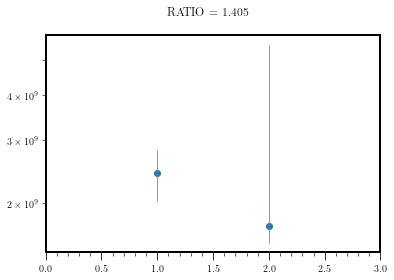

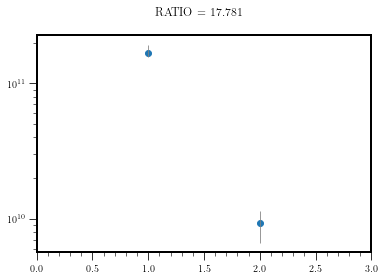

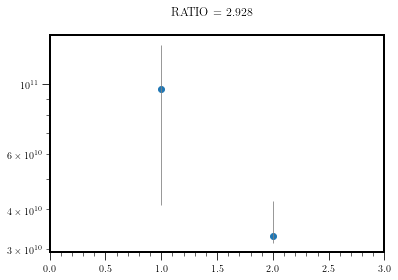

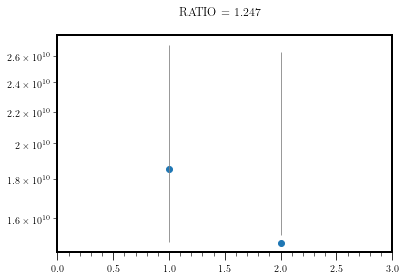

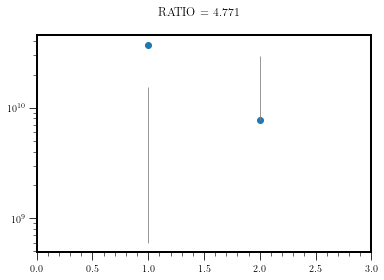

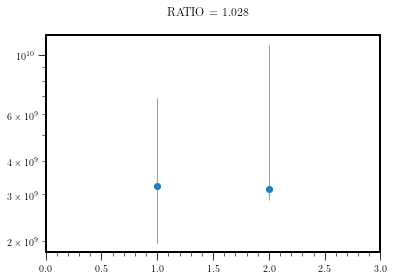

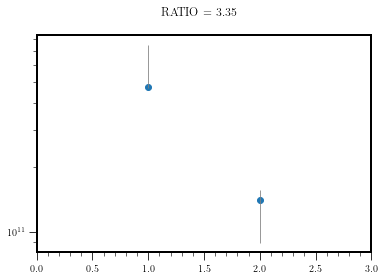

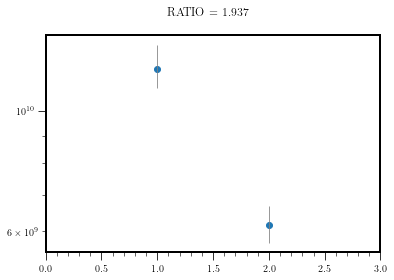

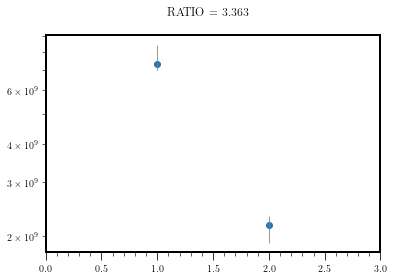

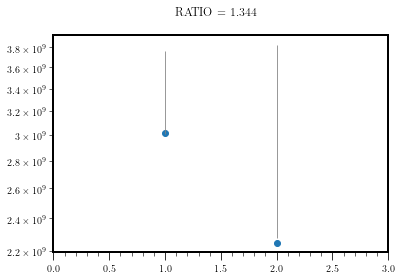

In [87]:
calc_mass_ratio(G5, R)

0 1


/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:1480: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  plt.scatter((df["RA"] - ra_qso.value)*3600, (df["DEC"] - dec_qso.value)*3600, \
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:1483: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  plt.scatter((df["RA"] - ra_qso.value)*3600, (df["DEC"] - dec_qso.value)*3600, \
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:1510: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  plt.scatter(df["r_to_gcenter"], df["vlos_to_gcenter"], \
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:1513: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  plt.scatter(df["r_to_gcenter"], df["vlos_to_gcenter"], \


2 2


/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:1480: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  plt.scatter((df["RA"] - ra_qso.value)*3600, (df["DEC"] - dec_qso.value)*3600, \
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:1483: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  plt.scatter((df["RA"] - ra_qso.value)*3600, (df["DEC"] - dec_qso.value)*3600, \
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:1510: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  plt.scatter(df["r_to_gcenter"], df["vlos_to_gcenter"], \
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:1513: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  plt.scatter(df["r_to_gcenter"], df["vlos_to_gcenter"], \


3 3


/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:1480: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  plt.scatter((df["RA"] - ra_qso.value)*3600, (df["DEC"] - dec_qso.value)*3600, \
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:1483: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  plt.scatter((df["RA"] - ra_qso.value)*3600, (df["DEC"] - dec_qso.value)*3600, \
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:1510: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  plt.scatter(df["r_to_gcenter"], df["vlos_to_gcenter"], \
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:1513: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  plt.scatter(df["r_to_gcenter"], df["vlos_to_gcenter"], \


4 4


/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:1480: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  plt.scatter((df["RA"] - ra_qso.value)*3600, (df["DEC"] - dec_qso.value)*3600, \
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:1483: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  plt.scatter((df["RA"] - ra_qso.value)*3600, (df["DEC"] - dec_qso.value)*3600, \
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:1510: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  plt.scatter(df["r_to_gcenter"], df["vlos_to_gcenter"], \
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:1513: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  plt.scatter(df["r_to_gcenter"], df["vlos_to_gcenter"], \


5 5


/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:1480: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  plt.scatter((df["RA"] - ra_qso.value)*3600, (df["DEC"] - dec_qso.value)*3600, \
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:1483: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  plt.scatter((df["RA"] - ra_qso.value)*3600, (df["DEC"] - dec_qso.value)*3600, \
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:1510: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  plt.scatter(df["r_to_gcenter"], df["vlos_to_gcenter"], \
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:1513: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  plt.scatter(df["r_to_gcenter"], df["vlos_to_gcenter"], \


6 6


/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:1480: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  plt.scatter((df["RA"] - ra_qso.value)*3600, (df["DEC"] - dec_qso.value)*3600, \
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:1483: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  plt.scatter((df["RA"] - ra_qso.value)*3600, (df["DEC"] - dec_qso.value)*3600, \
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:1510: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  plt.scatter(df["r_to_gcenter"], df["vlos_to_gcenter"], \
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:1513: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  plt.scatter(df["r_to_gcenter"], df["vlos_to_gcenter"], \


7 7


/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:1480: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  plt.scatter((df["RA"] - ra_qso.value)*3600, (df["DEC"] - dec_qso.value)*3600, \
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:1483: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  plt.scatter((df["RA"] - ra_qso.value)*3600, (df["DEC"] - dec_qso.value)*3600, \
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:1510: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  plt.scatter(df["r_to_gcenter"], df["vlos_to_gcenter"], \
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:1513: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  plt.scatter(df["r_to_gcenter"], df["vlos_to_gcenter"], \


9 8


/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:1480: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  plt.scatter((df["RA"] - ra_qso.value)*3600, (df["DEC"] - dec_qso.value)*3600, \
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:1483: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  plt.scatter((df["RA"] - ra_qso.value)*3600, (df["DEC"] - dec_qso.value)*3600, \
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:1510: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  plt.scatter(df["r_to_gcenter"], df["vlos_to_gcenter"], \
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:1513: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  plt.scatter(df["r_to_gcenter"], df["vlos_to_gcenter"], \


11 9


/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:1480: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  plt.scatter((df["RA"] - ra_qso.value)*3600, (df["DEC"] - dec_qso.value)*3600, \
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:1483: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  plt.scatter((df["RA"] - ra_qso.value)*3600, (df["DEC"] - dec_qso.value)*3600, \
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:1510: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  plt.scatter(df["r_to_gcenter"], df["vlos_to_gcenter"], \
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:1513: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  plt.scatter(df["r_to_gcenter"], df["vlos_to_gcenter"], \


12 10


/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:1480: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  plt.scatter((df["RA"] - ra_qso.value)*3600, (df["DEC"] - dec_qso.value)*3600, \
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:1483: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  plt.scatter((df["RA"] - ra_qso.value)*3600, (df["DEC"] - dec_qso.value)*3600, \
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:1510: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  plt.scatter(df["r_to_gcenter"], df["vlos_to_gcenter"], \
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:1513: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  plt.scatter(df["r_to_gcenter"], df["vlos_to_gcenter"], \


13 11


/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:1480: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  plt.scatter((df["RA"] - ra_qso.value)*3600, (df["DEC"] - dec_qso.value)*3600, \
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:1483: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  plt.scatter((df["RA"] - ra_qso.value)*3600, (df["DEC"] - dec_qso.value)*3600, \
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:1510: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  plt.scatter(df["r_to_gcenter"], df["vlos_to_gcenter"], \
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:1513: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  plt.scatter(df["r_to_gcenter"], df["vlos_to_gcenter"], \


14 12


/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:1480: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  plt.scatter((df["RA"] - ra_qso.value)*3600, (df["DEC"] - dec_qso.value)*3600, \
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:1483: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  plt.scatter((df["RA"] - ra_qso.value)*3600, (df["DEC"] - dec_qso.value)*3600, \
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:1510: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  plt.scatter(df["r_to_gcenter"], df["vlos_to_gcenter"], \
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:1513: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  plt.scatter(df["r_to_gcenter"], df["vlos_to_gcenter"], \


16 13


/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:1480: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  plt.scatter((df["RA"] - ra_qso.value)*3600, (df["DEC"] - dec_qso.value)*3600, \
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:1483: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  plt.scatter((df["RA"] - ra_qso.value)*3600, (df["DEC"] - dec_qso.value)*3600, \
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:1510: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  plt.scatter(df["r_to_gcenter"], df["vlos_to_gcenter"], \
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:1513: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  plt.scatter(df["r_to_gcenter"], df["vlos_to_gcenter"], \


17 14


/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:1480: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  plt.scatter((df["RA"] - ra_qso.value)*3600, (df["DEC"] - dec_qso.value)*3600, \
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:1483: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  plt.scatter((df["RA"] - ra_qso.value)*3600, (df["DEC"] - dec_qso.value)*3600, \
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:1510: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  plt.scatter(df["r_to_gcenter"], df["vlos_to_gcenter"], \
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:1513: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  plt.scatter(df["r_to_gcenter"], df["vlos_to_gcenter"], \


18 15


/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:1480: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  plt.scatter((df["RA"] - ra_qso.value)*3600, (df["DEC"] - dec_qso.value)*3600, \
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:1483: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  plt.scatter((df["RA"] - ra_qso.value)*3600, (df["DEC"] - dec_qso.value)*3600, \
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:1510: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  plt.scatter(df["r_to_gcenter"], df["vlos_to_gcenter"], \
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:1513: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  plt.scatter(df["r_to_gcenter"], df["vlos_to_gcenter"], \


19 16


/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:1480: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  plt.scatter((df["RA"] - ra_qso.value)*3600, (df["DEC"] - dec_qso.value)*3600, \
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:1483: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  plt.scatter((df["RA"] - ra_qso.value)*3600, (df["DEC"] - dec_qso.value)*3600, \
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:1510: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  plt.scatter(df["r_to_gcenter"], df["vlos_to_gcenter"], \
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:1513: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  plt.scatter(df["r_to_gcenter"], df["vlos_to_gcenter"], \


20 17


/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:1480: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  plt.scatter((df["RA"] - ra_qso.value)*3600, (df["DEC"] - dec_qso.value)*3600, \
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:1483: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  plt.scatter((df["RA"] - ra_qso.value)*3600, (df["DEC"] - dec_qso.value)*3600, \
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:1510: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  plt.scatter(df["r_to_gcenter"], df["vlos_to_gcenter"], \
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:1513: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  plt.scatter(df["r_to_gcenter"], df["vlos_to_gcenter"], \


22 18


/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:1480: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  plt.scatter((df["RA"] - ra_qso.value)*3600, (df["DEC"] - dec_qso.value)*3600, \
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:1483: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  plt.scatter((df["RA"] - ra_qso.value)*3600, (df["DEC"] - dec_qso.value)*3600, \
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:1510: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  plt.scatter(df["r_to_gcenter"], df["vlos_to_gcenter"], \
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:1513: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  plt.scatter(df["r_to_gcenter"], df["vlos_to_gcenter"], \


23 19


/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:1480: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  plt.scatter((df["RA"] - ra_qso.value)*3600, (df["DEC"] - dec_qso.value)*3600, \
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:1483: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  plt.scatter((df["RA"] - ra_qso.value)*3600, (df["DEC"] - dec_qso.value)*3600, \
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:1510: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  plt.scatter(df["r_to_gcenter"], df["vlos_to_gcenter"], \
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:1513: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  plt.scatter(df["r_to_gcenter"], df["vlos_to_gcenter"], \


24 20


/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:1480: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  plt.scatter((df["RA"] - ra_qso.value)*3600, (df["DEC"] - dec_qso.value)*3600, \
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:1483: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  plt.scatter((df["RA"] - ra_qso.value)*3600, (df["DEC"] - dec_qso.value)*3600, \
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:1510: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  plt.scatter(df["r_to_gcenter"], df["vlos_to_gcenter"], \
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:1513: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  plt.scatter(df["r_to_gcenter"], df["vlos_to_gcenter"], \


25 21


/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:1480: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  plt.scatter((df["RA"] - ra_qso.value)*3600, (df["DEC"] - dec_qso.value)*3600, \
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:1483: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  plt.scatter((df["RA"] - ra_qso.value)*3600, (df["DEC"] - dec_qso.value)*3600, \
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:1510: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  plt.scatter(df["r_to_gcenter"], df["vlos_to_gcenter"], \
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:1513: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  plt.scatter(df["r_to_gcenter"], df["vlos_to_gcenter"], \


26 22


/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:1480: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  plt.scatter((df["RA"] - ra_qso.value)*3600, (df["DEC"] - dec_qso.value)*3600, \
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:1483: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  plt.scatter((df["RA"] - ra_qso.value)*3600, (df["DEC"] - dec_qso.value)*3600, \
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:1510: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  plt.scatter(df["r_to_gcenter"], df["vlos_to_gcenter"], \
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:1513: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  plt.scatter(df["r_to_gcenter"], df["vlos_to_gcenter"], \


27 23


/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:1480: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  plt.scatter((df["RA"] - ra_qso.value)*3600, (df["DEC"] - dec_qso.value)*3600, \
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:1483: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  plt.scatter((df["RA"] - ra_qso.value)*3600, (df["DEC"] - dec_qso.value)*3600, \
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:1510: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  plt.scatter(df["r_to_gcenter"], df["vlos_to_gcenter"], \
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:1513: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  plt.scatter(df["r_to_gcenter"], df["vlos_to_gcenter"], \


28 24


/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:1480: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  plt.scatter((df["RA"] - ra_qso.value)*3600, (df["DEC"] - dec_qso.value)*3600, \
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:1483: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  plt.scatter((df["RA"] - ra_qso.value)*3600, (df["DEC"] - dec_qso.value)*3600, \
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:1510: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  plt.scatter(df["r_to_gcenter"], df["vlos_to_gcenter"], \
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:1513: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  plt.scatter(df["r_to_gcenter"], df["vlos_to_gcenter"], \


30 25


/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:1480: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  plt.scatter((df["RA"] - ra_qso.value)*3600, (df["DEC"] - dec_qso.value)*3600, \
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:1483: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  plt.scatter((df["RA"] - ra_qso.value)*3600, (df["DEC"] - dec_qso.value)*3600, \
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:1510: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  plt.scatter(df["r_to_gcenter"], df["vlos_to_gcenter"], \
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:1513: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  plt.scatter(df["r_to_gcenter"], df["vlos_to_gcenter"], \


31 26


/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:1480: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  plt.scatter((df["RA"] - ra_qso.value)*3600, (df["DEC"] - dec_qso.value)*3600, \
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:1483: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  plt.scatter((df["RA"] - ra_qso.value)*3600, (df["DEC"] - dec_qso.value)*3600, \
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:1510: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  plt.scatter(df["r_to_gcenter"], df["vlos_to_gcenter"], \
/home/mcherrey/ownCloud/git_groups/Phd_groups/groups_tools.py:1513: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  plt.scatter(df["r_to_gcenter"], df["vlos_to_gcenter"], \


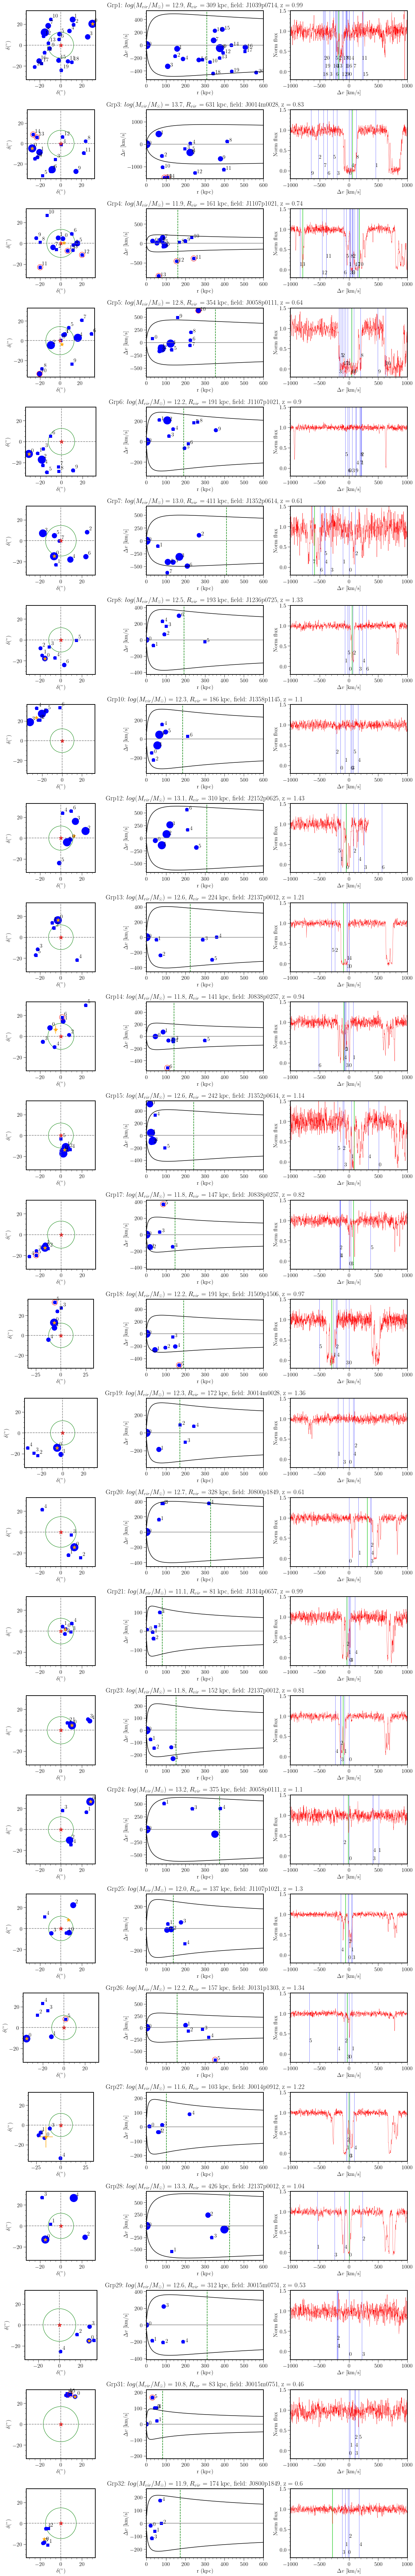

In [107]:
gid.plot_groups_2(R, G5)

In [89]:
G5.columns

Index(['index', 'field_id', 'group_id', 'N_gal', 'mean_z', 'mean_ra',
       'mean_dec', 'b_min_kpc', 'Mvir_sigma2', 'Mvir_sigma3', 'Rvir_sigma2',
       'Rvir_sigma3', 'Mstar', 'm1_m2_ratio', 'center_ra', 'center_dec',
       'center_z', 'center_ra_err', 'center_dec_err', 'center_z_err',
       'Mvir_sigma2_error', 'Rvir_sigma2_error', 'Mvir_sigma3_error',
       'Rvir_sigma3_error', 'Rmax', 'sigma_v', 'sigma_v_error', 'ID',
       'EXPTIME(s)', 'PSF_qso', 'Comments_qso', 'zqso_sdss', 'depth_qso',
       'ebv_sfd_qso', 'ebv_sandf_qso', 'ebv_planck_qso', 'HST_qso', 'rmag_qso',
       'ra_qso', 'dec_qso', 'N100', 'N200', 'N100_los', 'dist', 'b_center_kpc',
       'b_geomcenter_kpc', 'b_center_err', 'b_min_kpc_norm2',
       'b_center_kpc_norm2', 'b_geomcenter_kpc_norm2', 'b_min_kpc_norm2_err',
       'b_center_kpc_norm2_err', 'b_geomcenter_kpc_norm2_err',
       'b_min_kpc_norm3', 'b_center_kpc_norm3', 'b_geomcenter_kpc_norm3',
       'b_min_kpc_norm3_err', 'b_center_kpc_norm3_err',
   

for i, g in G5.iterrows():
    ra_c = g["center_ra"]* u.degree
    dec_c = g["center_dec"]*u.degree
    ra_c_err = (g["center_ra"] + g["center_ra_err"])*u.degree
    dec_c_err = (g["center_dec"] + g["center_dec_err"])*u.degree
    
    ra_qso = g["ra_qso"]* u.degree
    dec_qso = g["dec_qso"]*u.degree
    c1 = SkyCoord(ra_c, dec_c)
    c2 = SkyCoord(ra_qso, dec_c)
    c3 = SkyCoord(ra_c, dec_qso)
    c4 = SkyCoord(ra_c_err, dec_c)
    c5 = SkyCoord(ra_c, dec_c_err)
    
    ra_sep = c1.separation(c2)
    dec_sep = c1.separation(c3)
    ra_err_sep = c1.separation(c4)
    dec_err_sep = c1.separation(c5)
    ra_dist = ra_sep.radian*Distance(unit=u.kpc, z=g["center_z"]).value / ((1 + g["center_z"]) ** 2)
    dec_dist = dec_sep.radian*Distance(unit=u.kpc, z=g["center_z"]).value / ((1 + g["center_z"]) ** 2)
    ra_err_dist = ra_err_sep.radian*Distance(unit=u.kpc, z=g["center_z"]).value / ((1 + g["center_z"]) ** 2)
    dec_err_dist = dec_err_sep.radian*Distance(unit=u.kpc, z=g["center_z"]).value / ((1 + g["center_z"]) ** 2)
    #df["r_to_gcenter"] = sep.radian * Distance(unit=u.kpc, z=z_center).value / ((1 + z_center) ** 2)
    #print("dist =", ra_dist, dec_dist)
    b_kpc = (ra_dist**2 + dec_dist**2)**0.5 
    
    #print(b_kpc, g["b_center_kpc"])
    #print("errors = ", ra_err_dist, dec_err_dist)
    b_ra_err = ra_dist*ra_err_dist/b_kpc
    b_dec_err = dec_dist*dec_err_dist/b_kpc
    
    b_err = b_ra_err + b_dec_err
    
    print("b error = ", b_err, " -----ra_contribution = ", b_ra_err, "---dec_contribution = ", b_dec_err)
    print("------------------------------------------ra_err = ", ra_err_dist, "------------dec_err = ", dec_err_dist)

#### 

In [90]:
51.51 - 6.75 - 3.10 - 2.99 - 2.14 - 4.75 - 0.37

31.409999999999993

In [1]:
10**2.12

131.82567385564073